In [5]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import glob

path_to_data = "/data/vision/polina/users/ramyamut/projects/mri_final_project/data"
random_file_path = sorted(glob.glob(f"{path_to_data}/brain_multicoil_test/*.h5"))[0]
random_file = h5py.File(random_file_path)
kspace = random_file["kspace"]
kspace_arr = np.array(kspace)

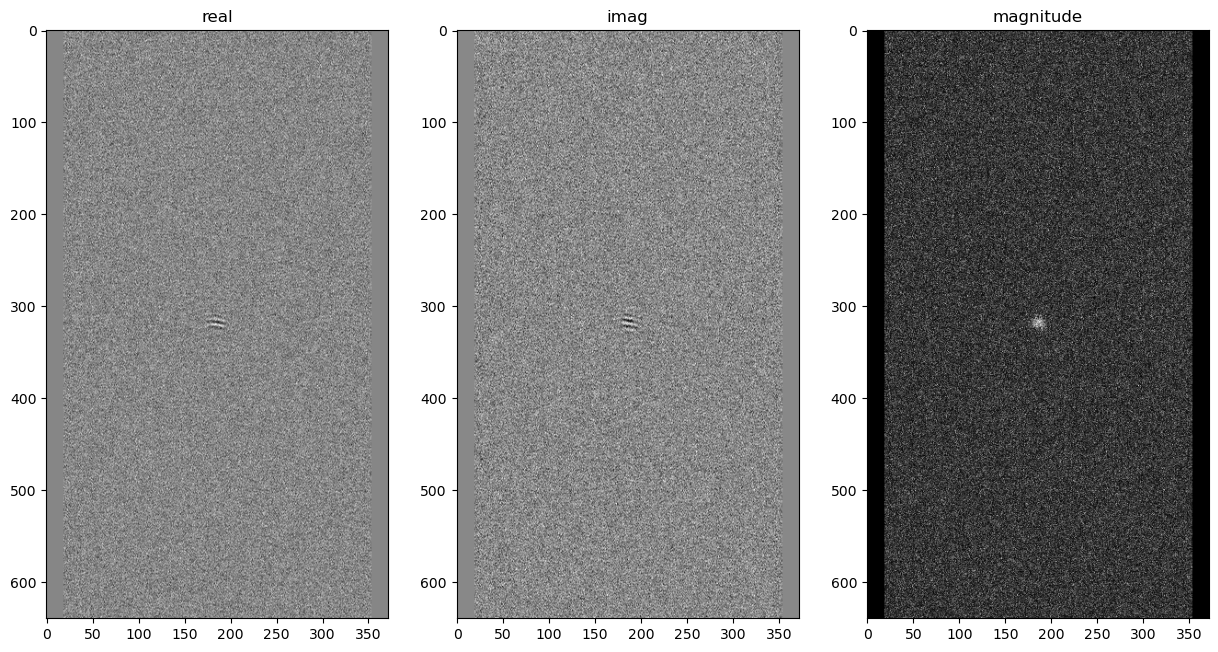

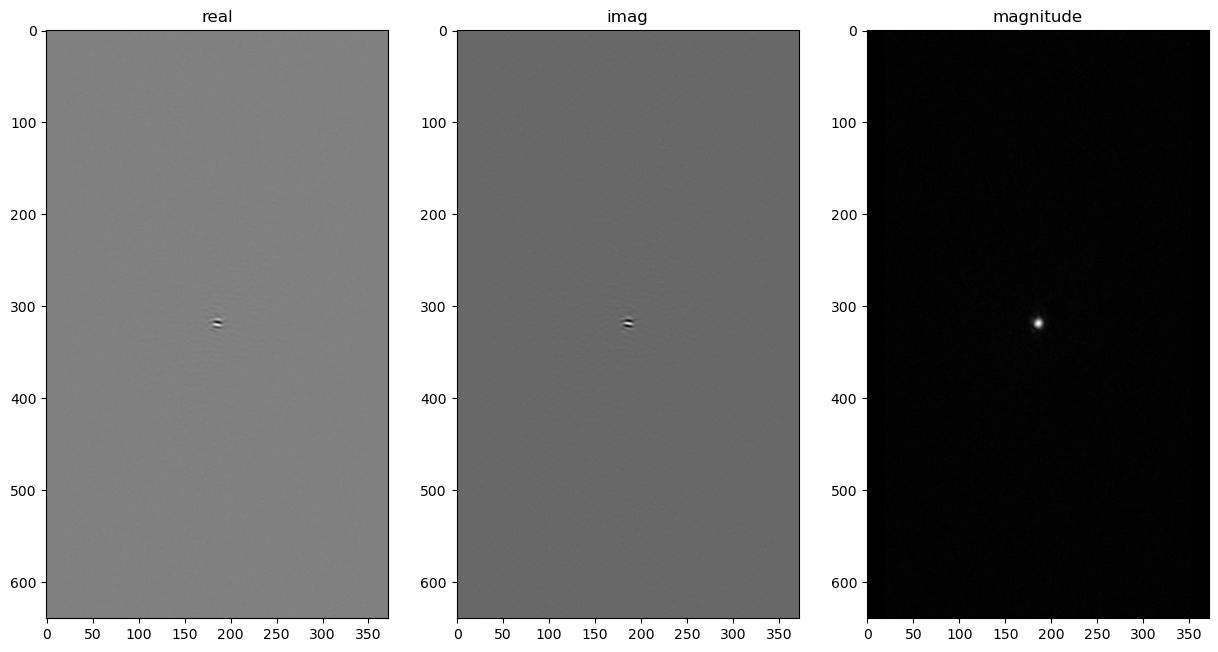

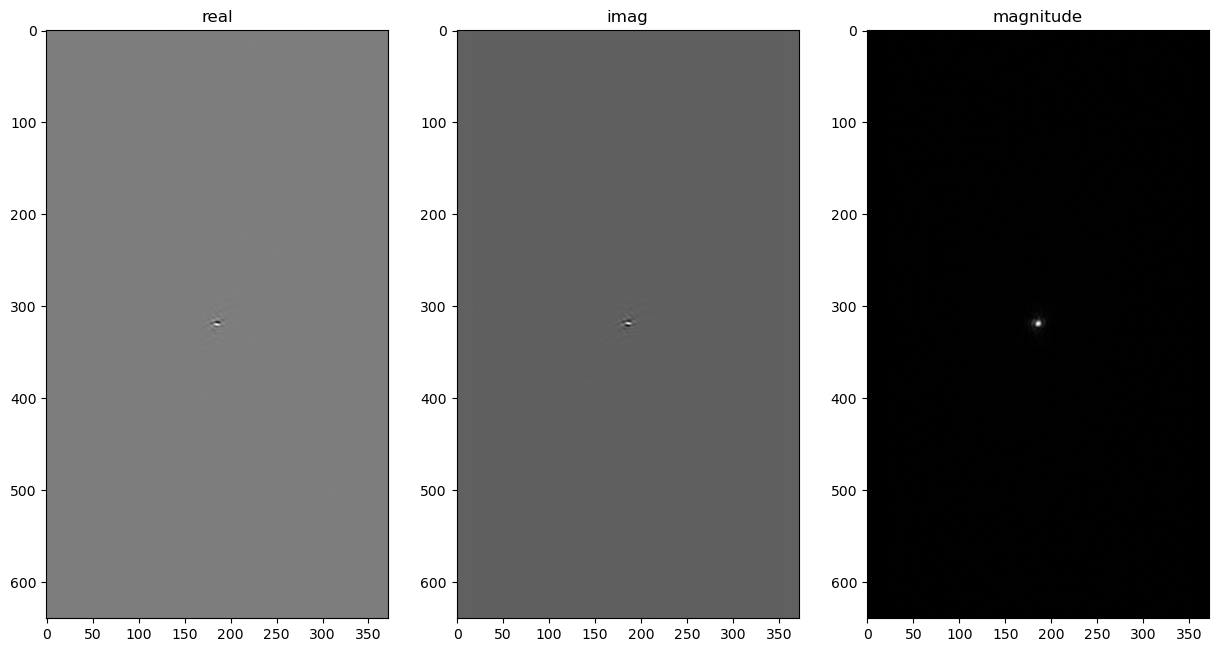

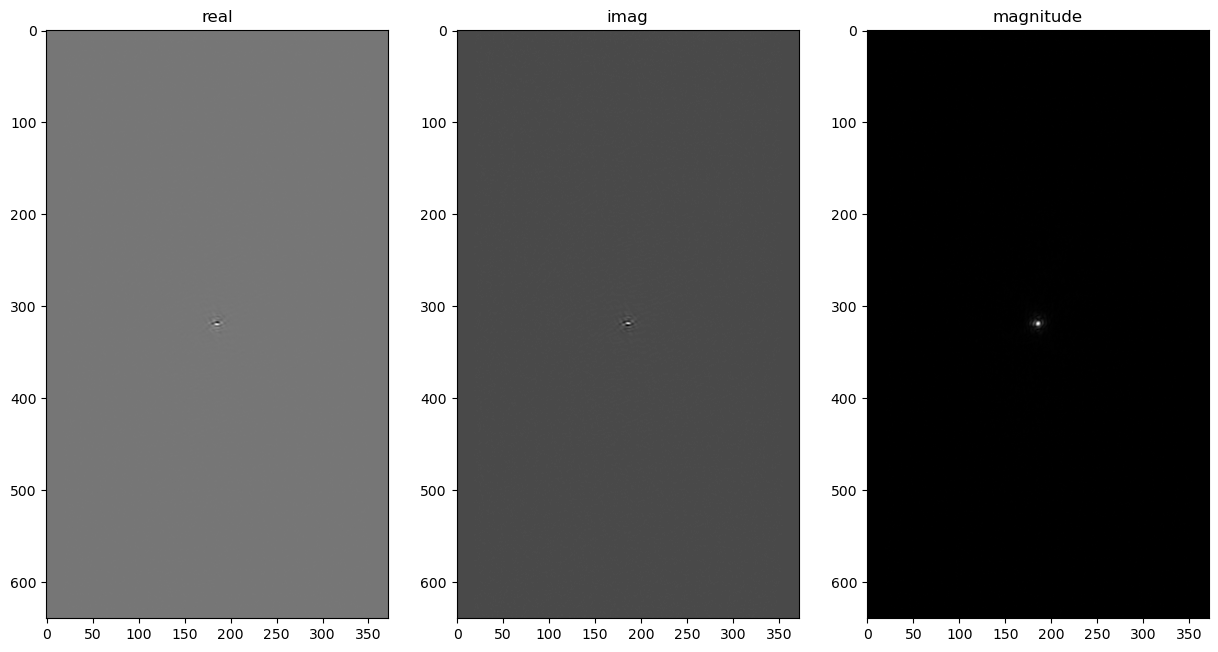

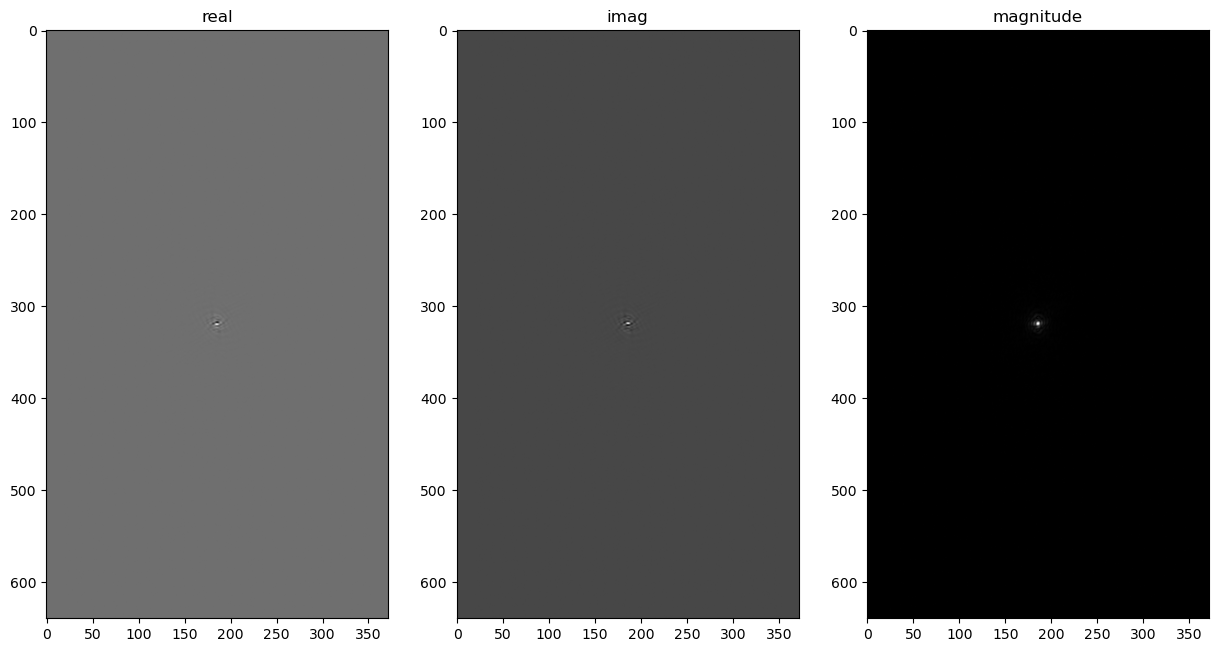

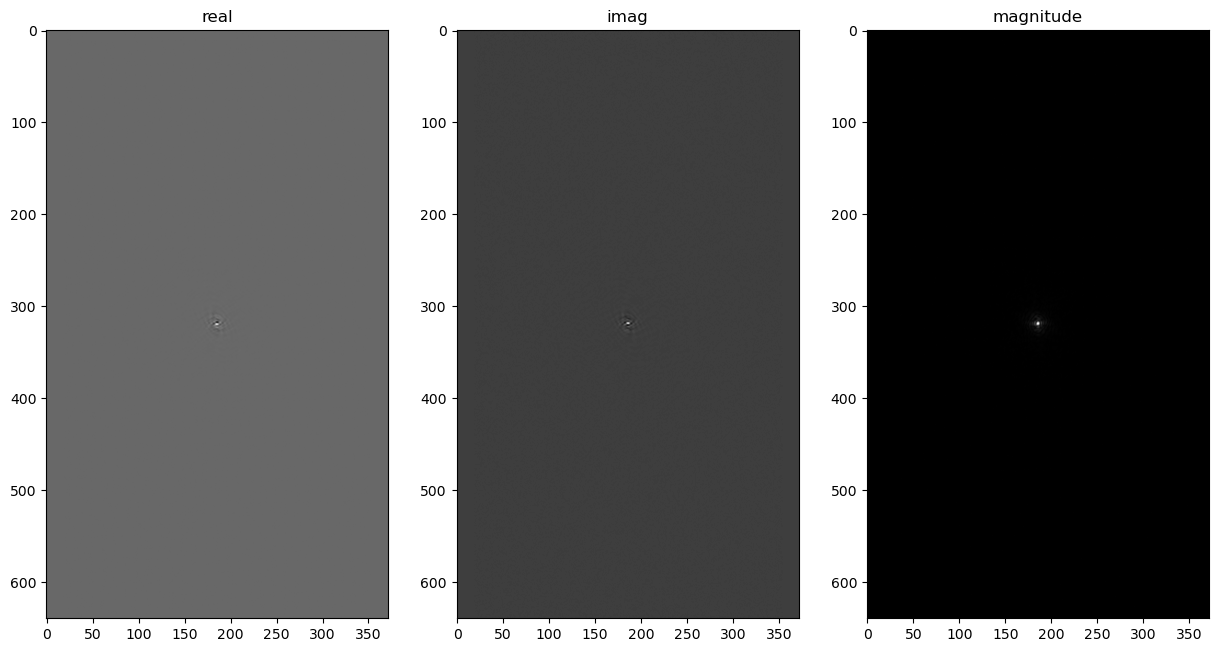

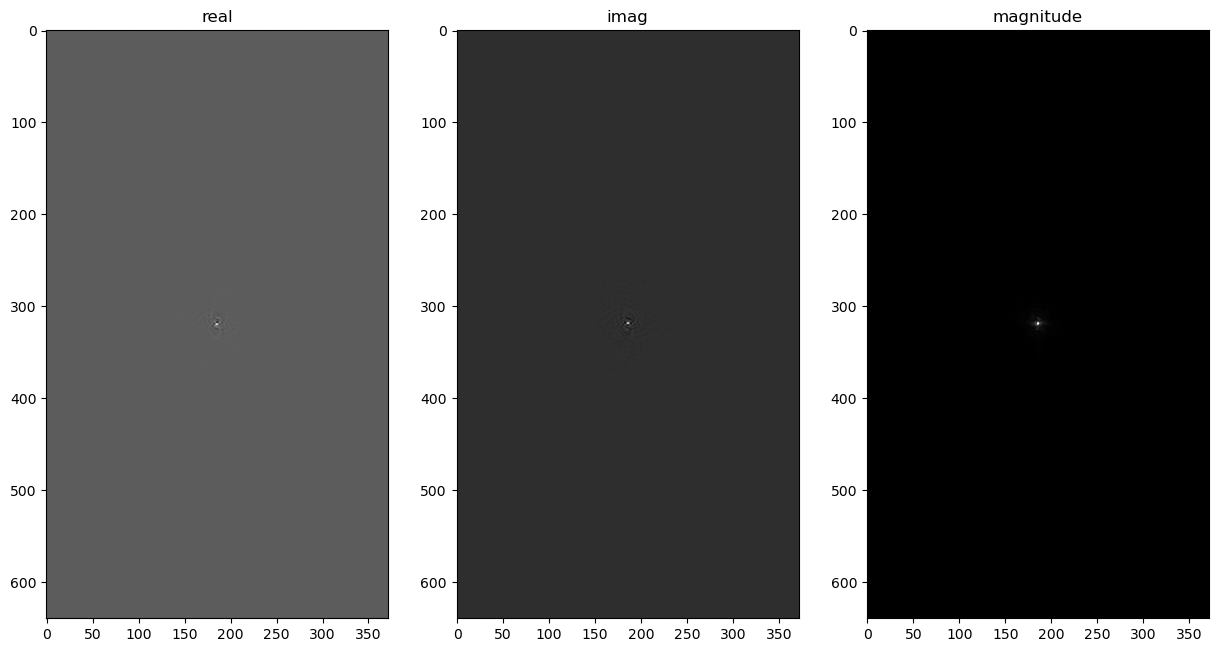

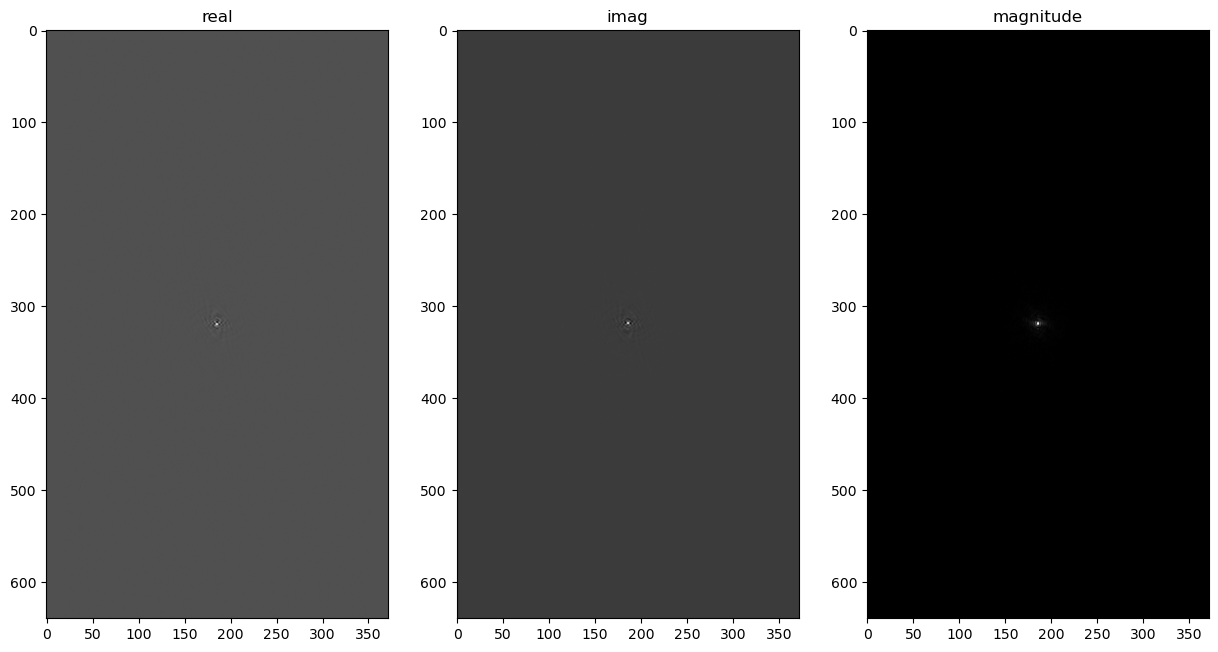

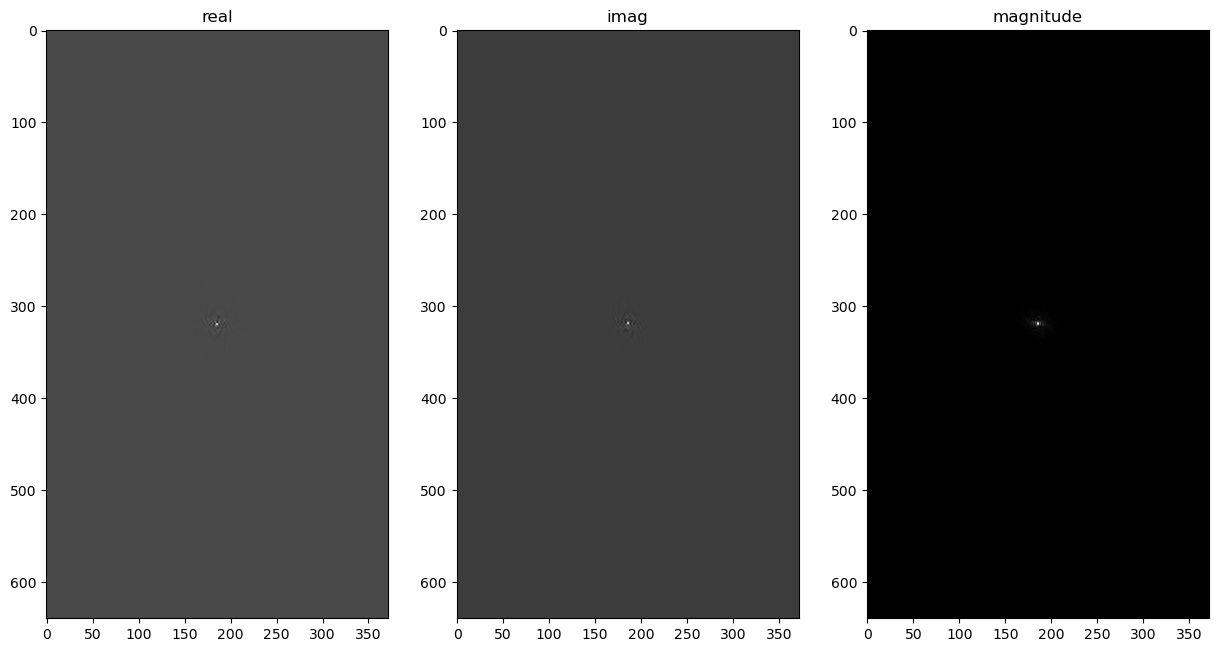

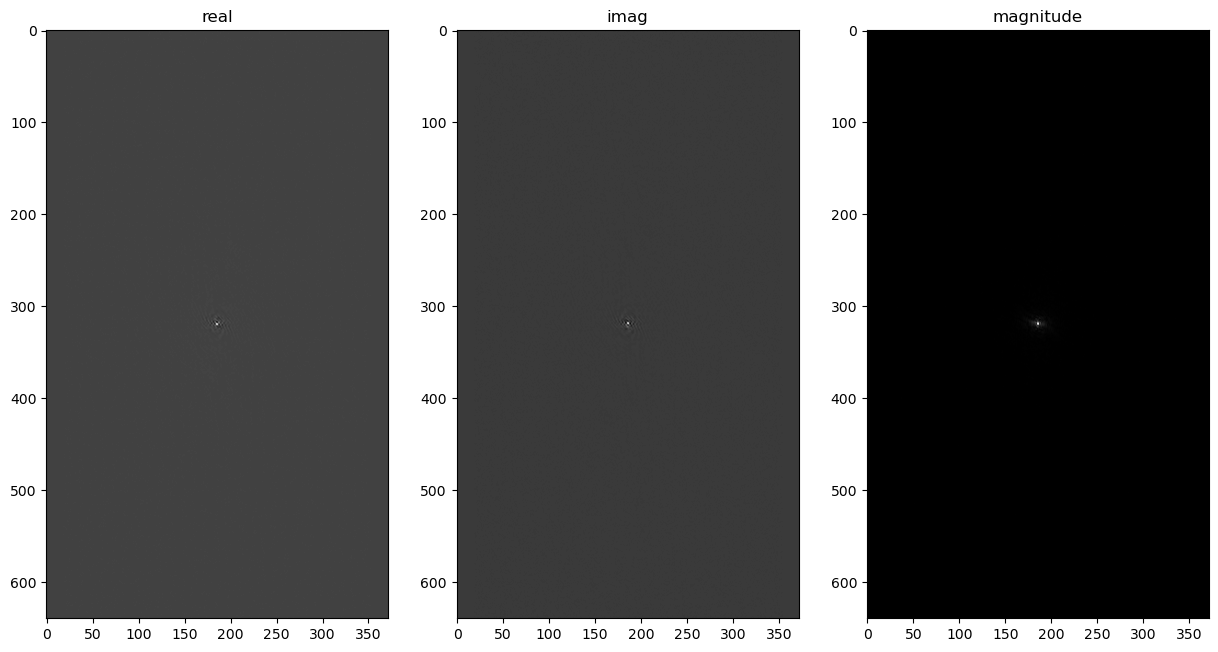

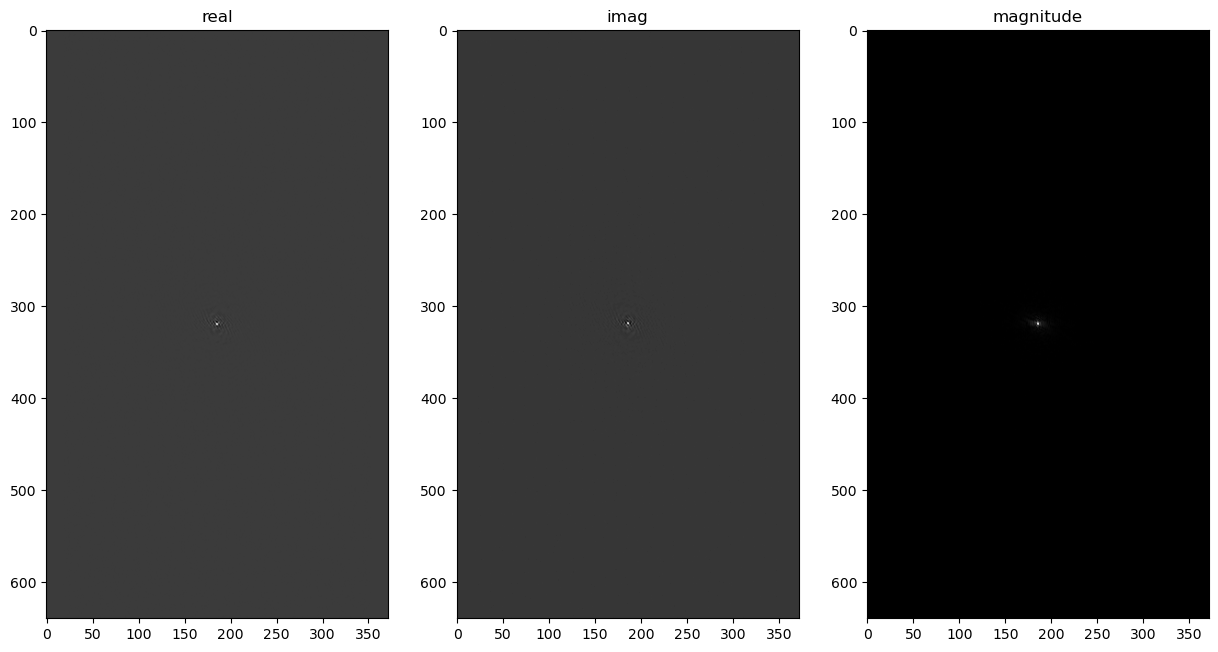

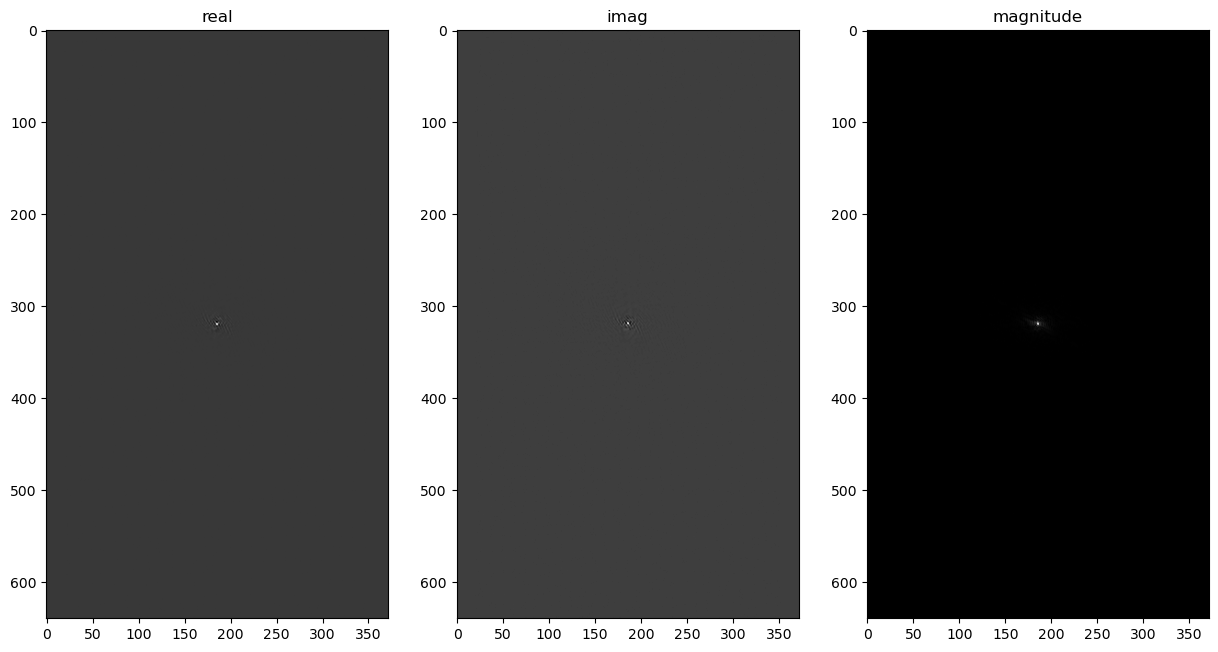

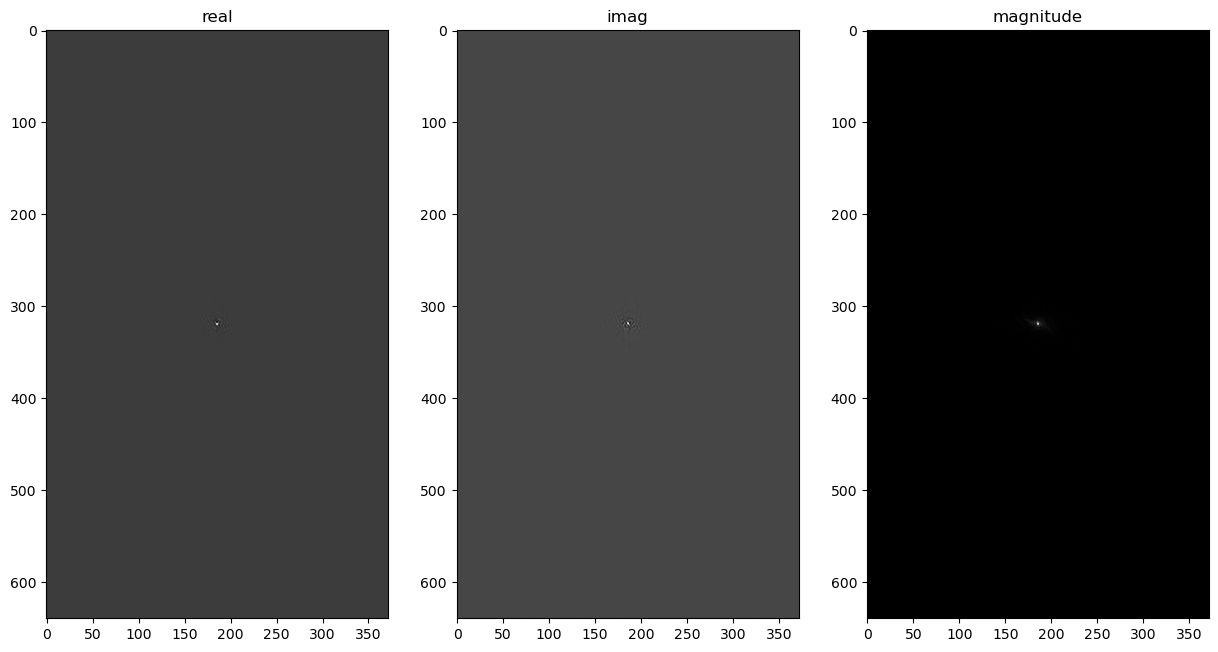

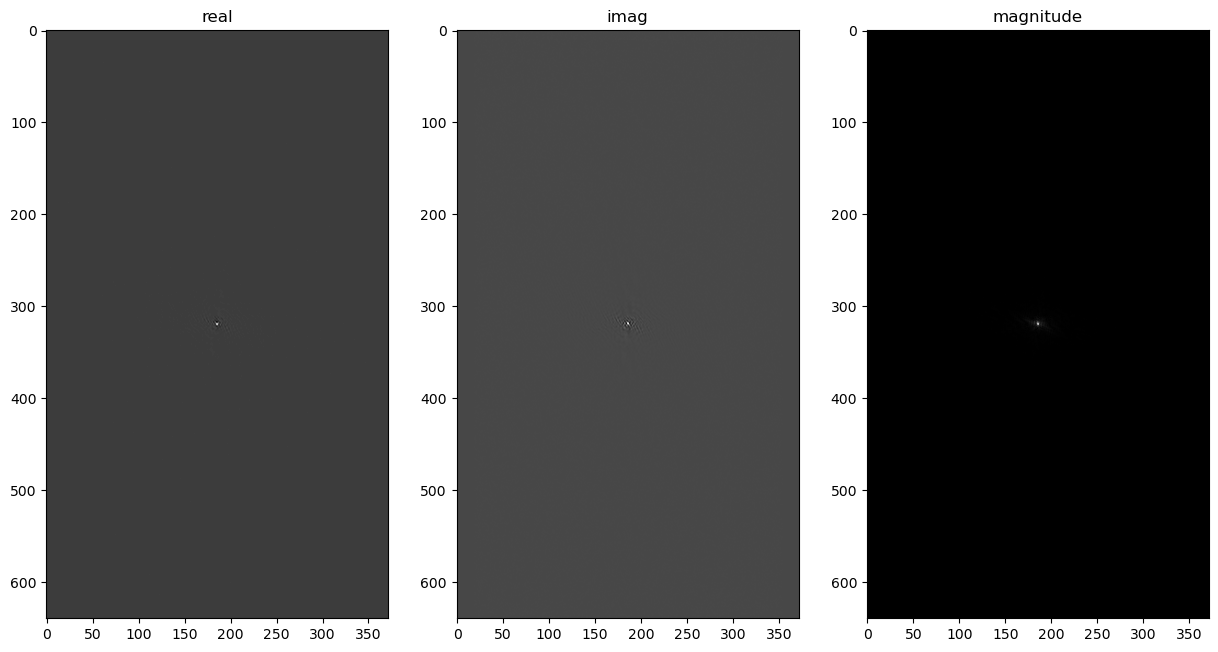

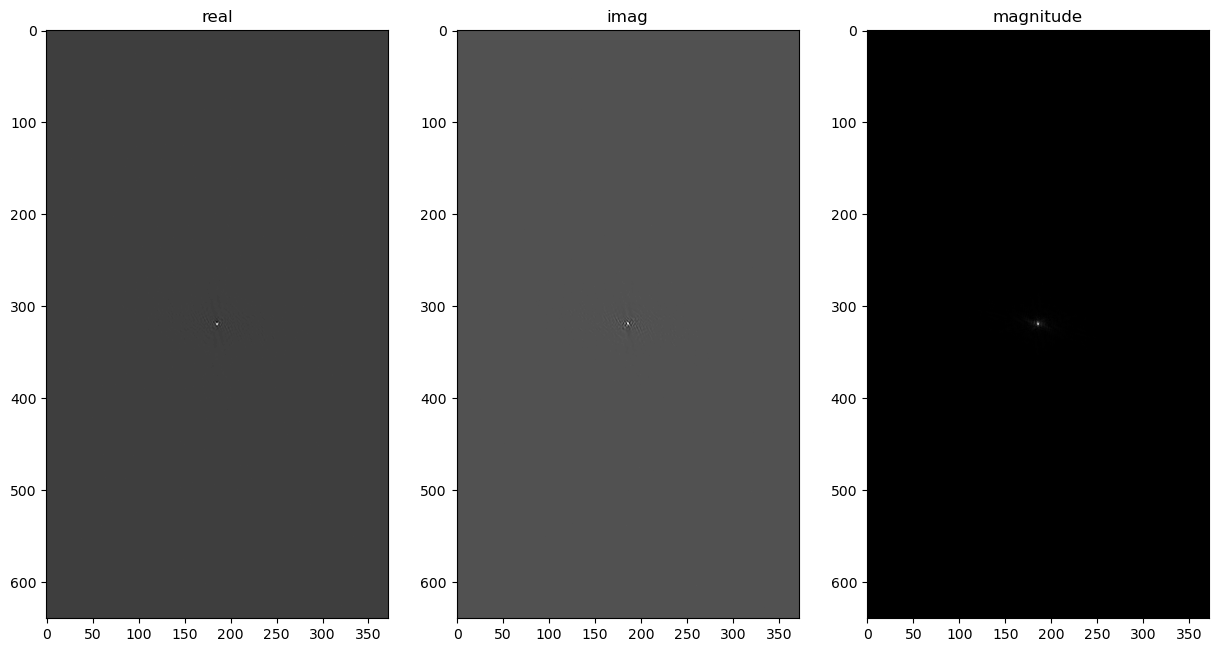

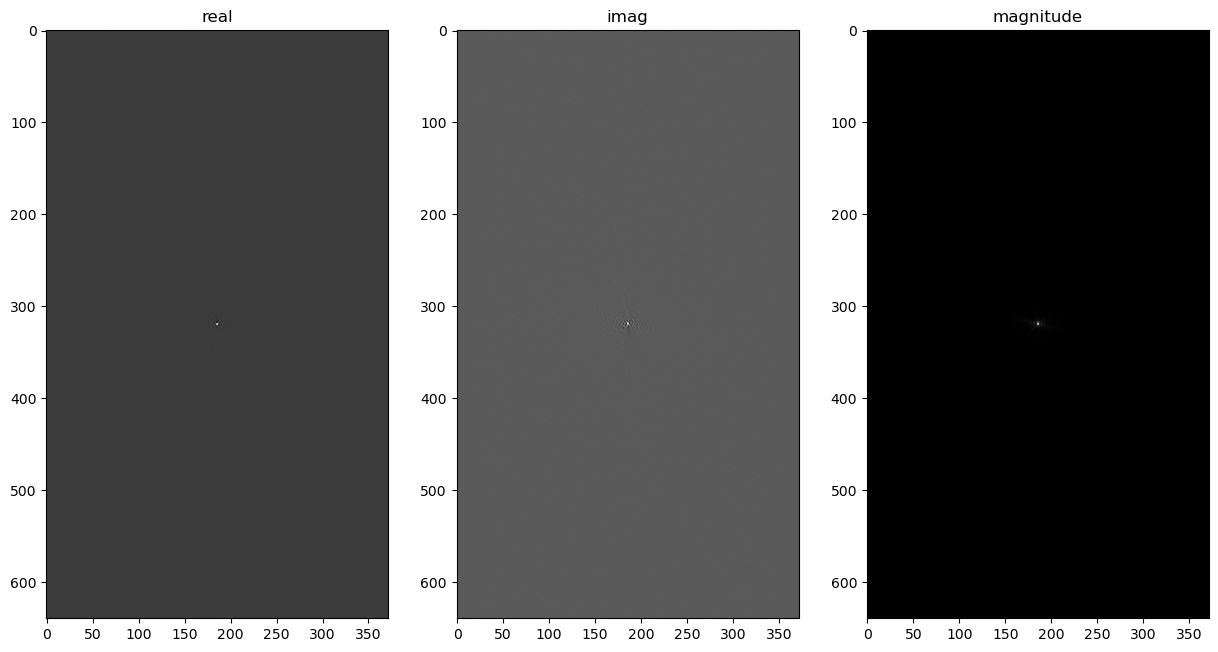

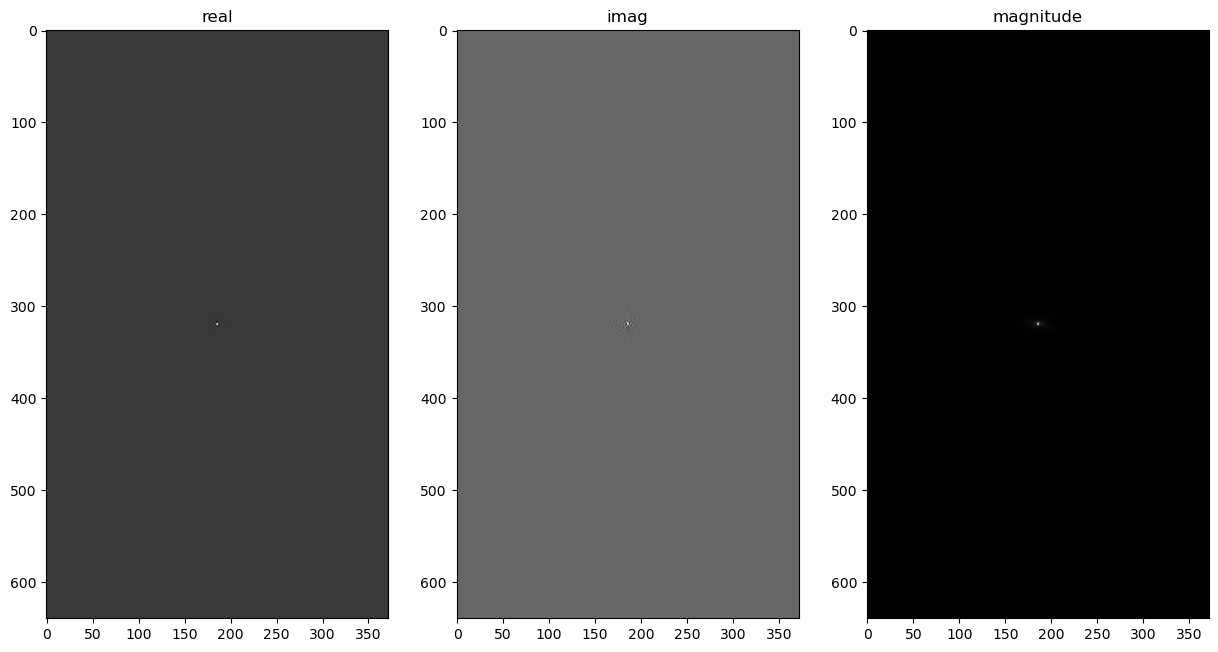

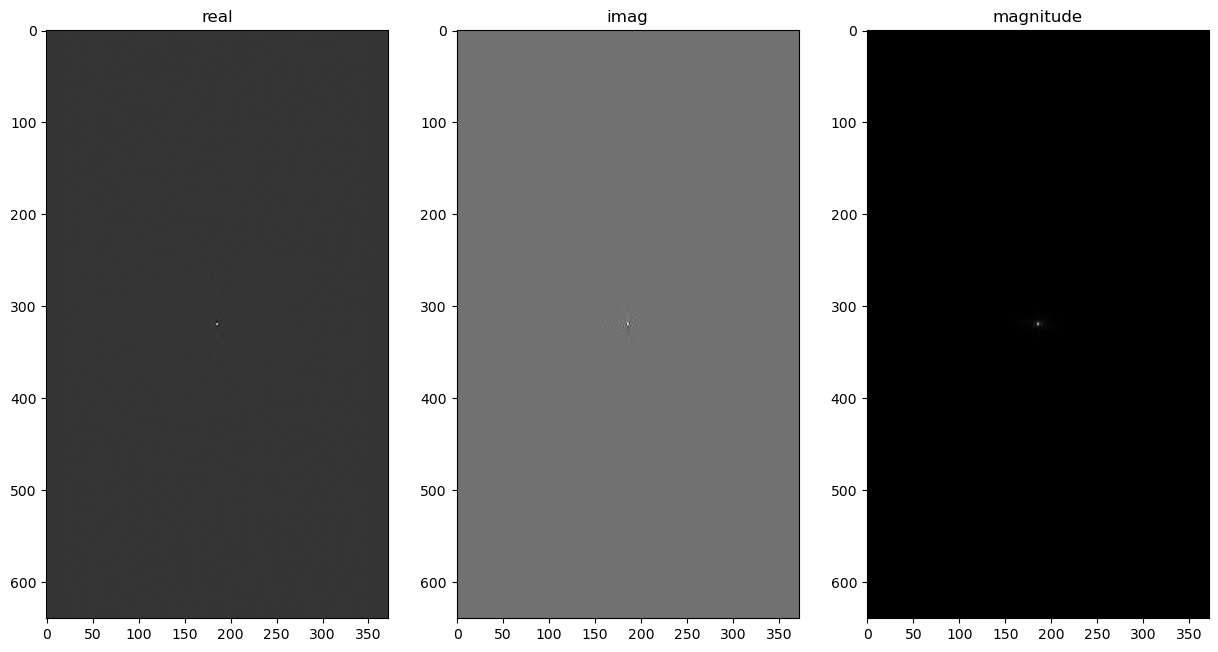

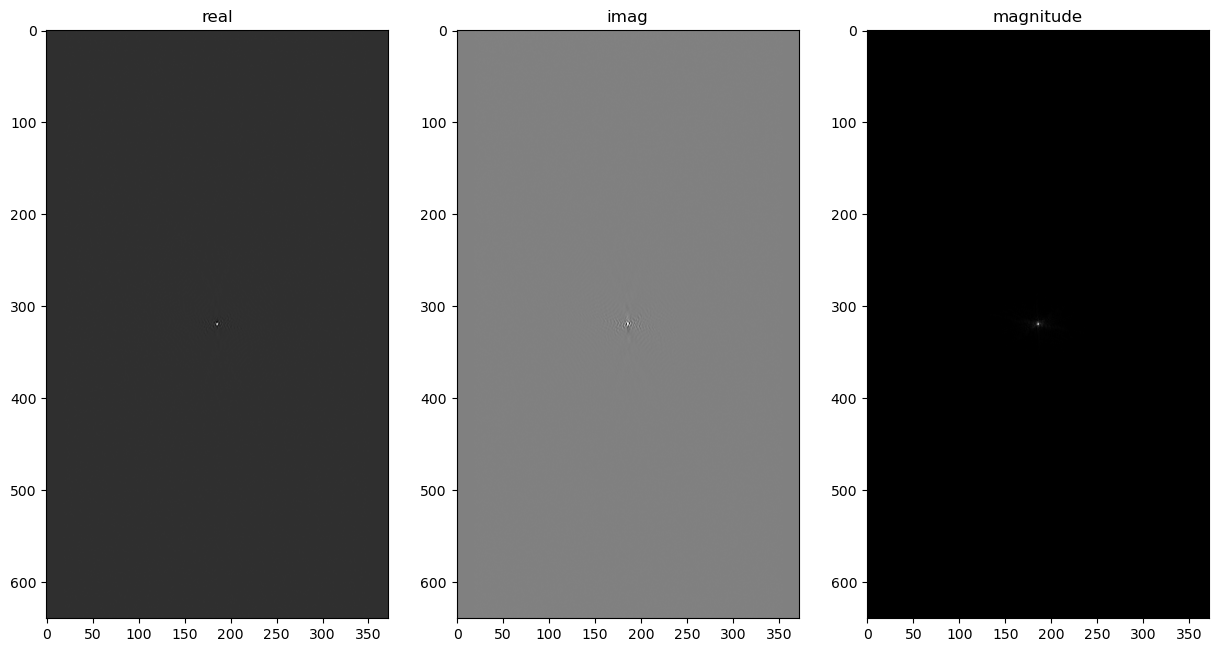

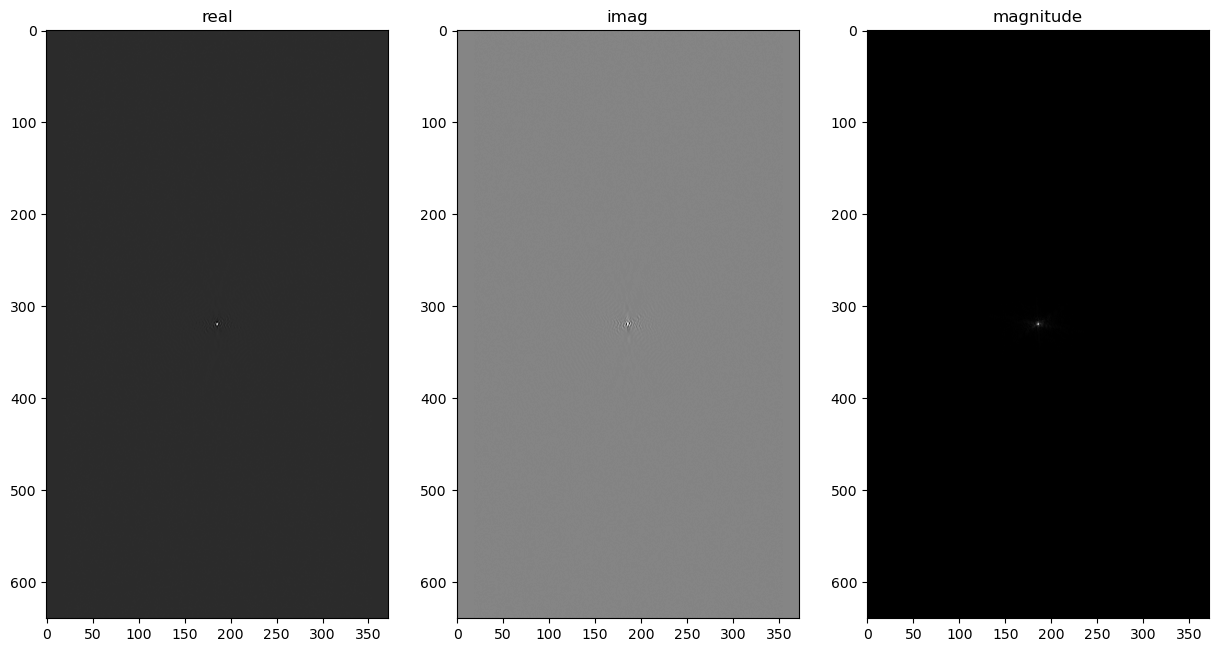

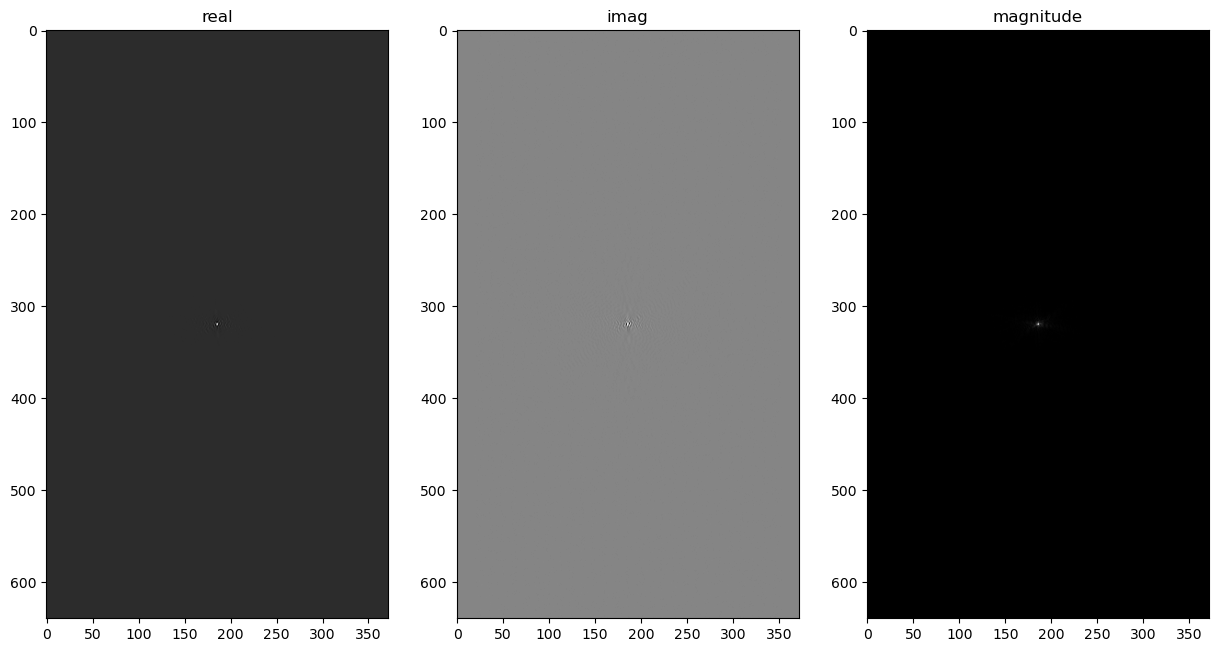

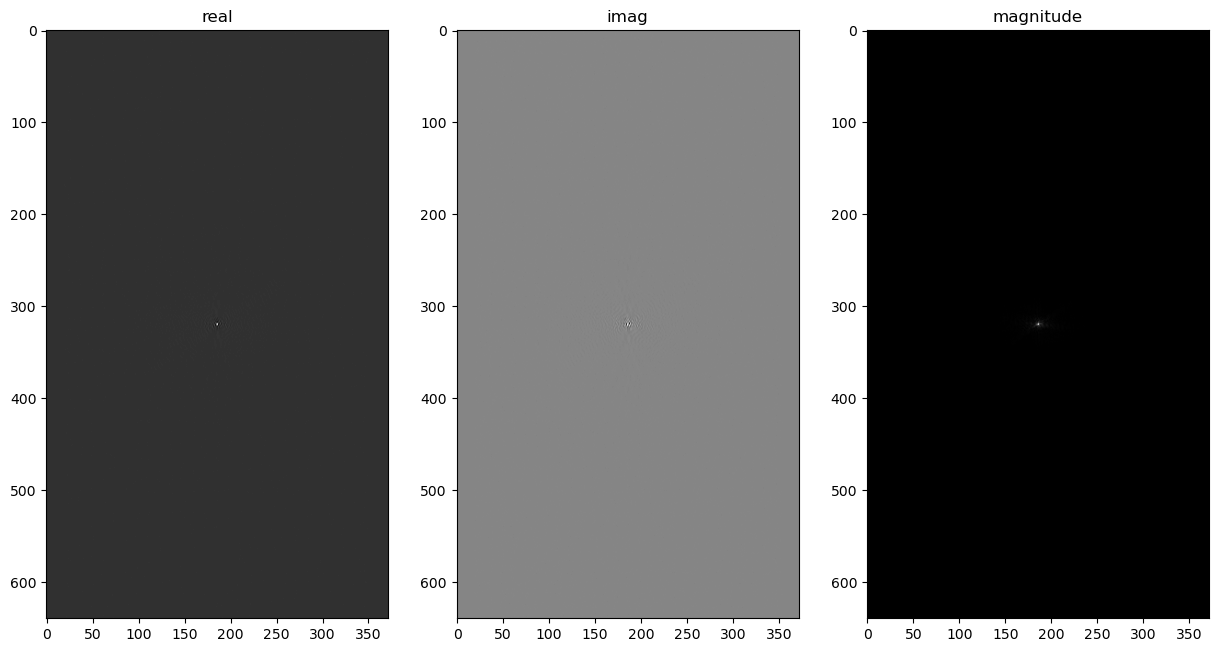

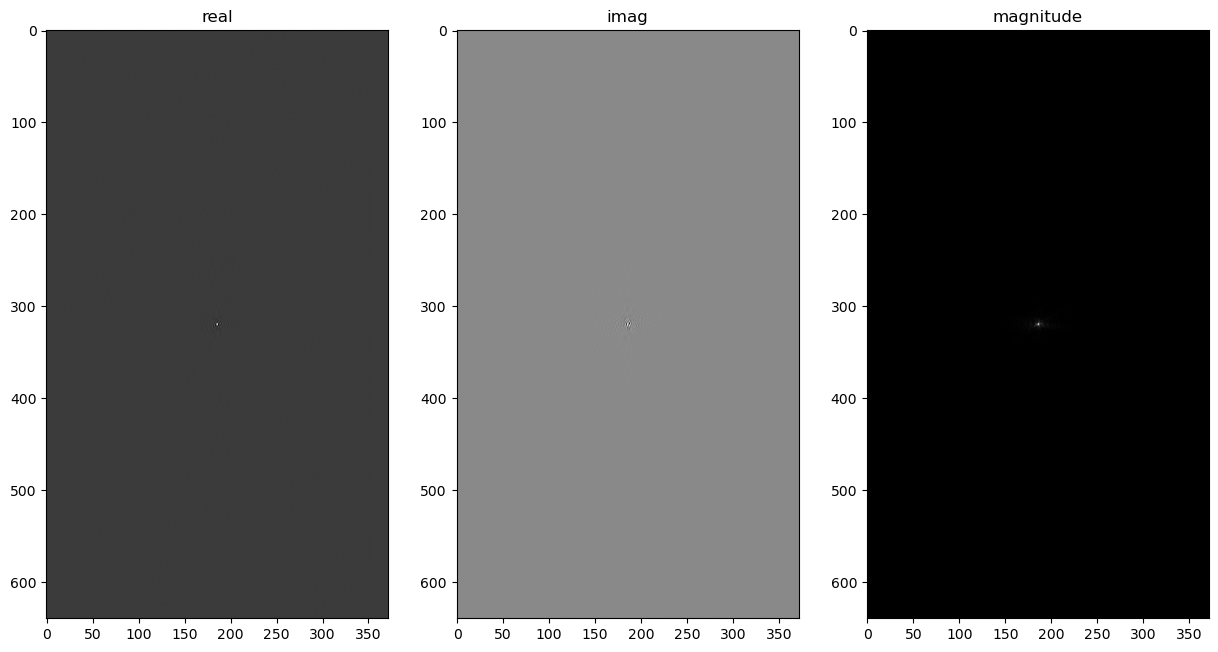

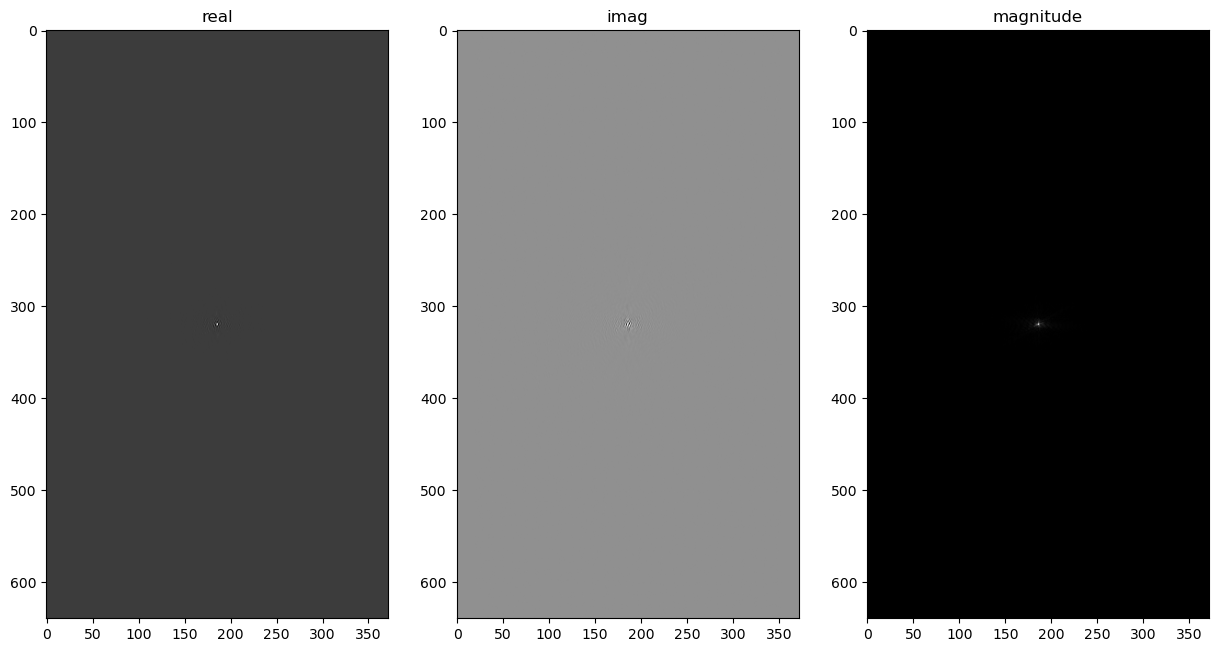

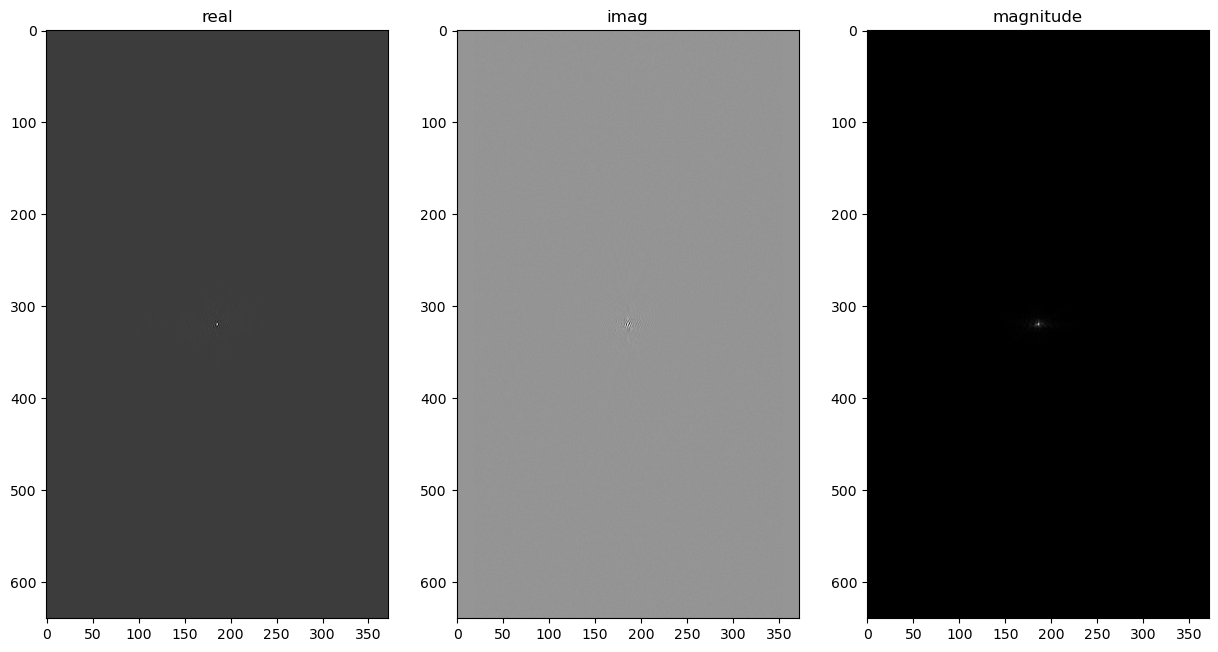

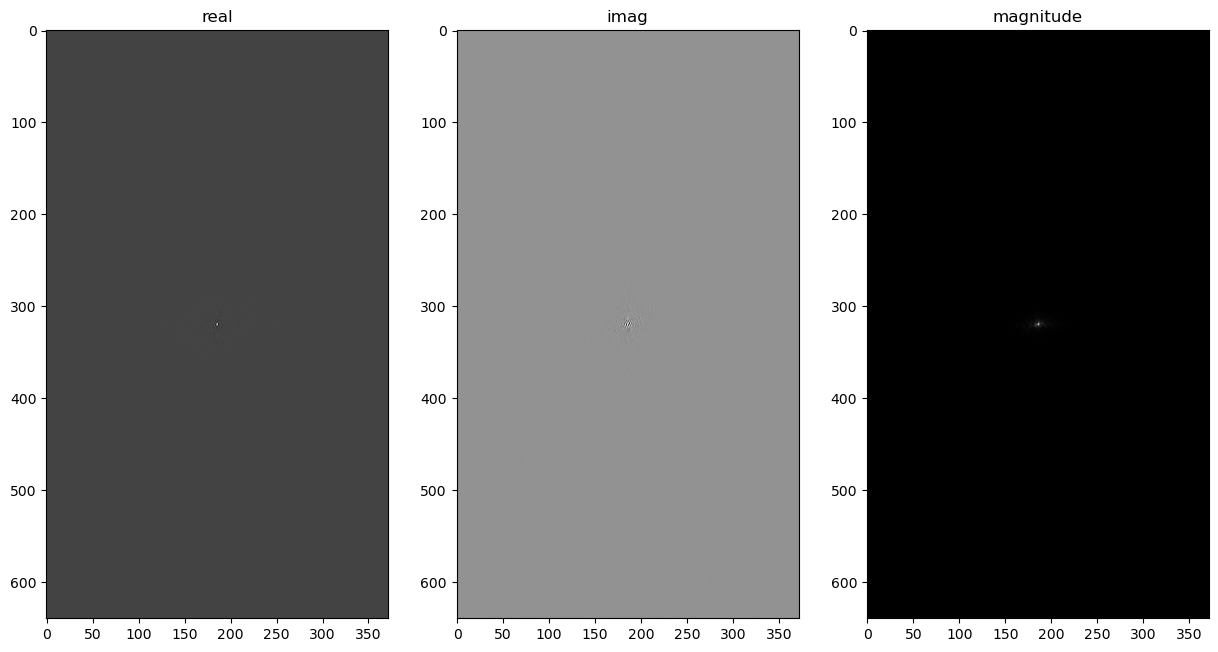

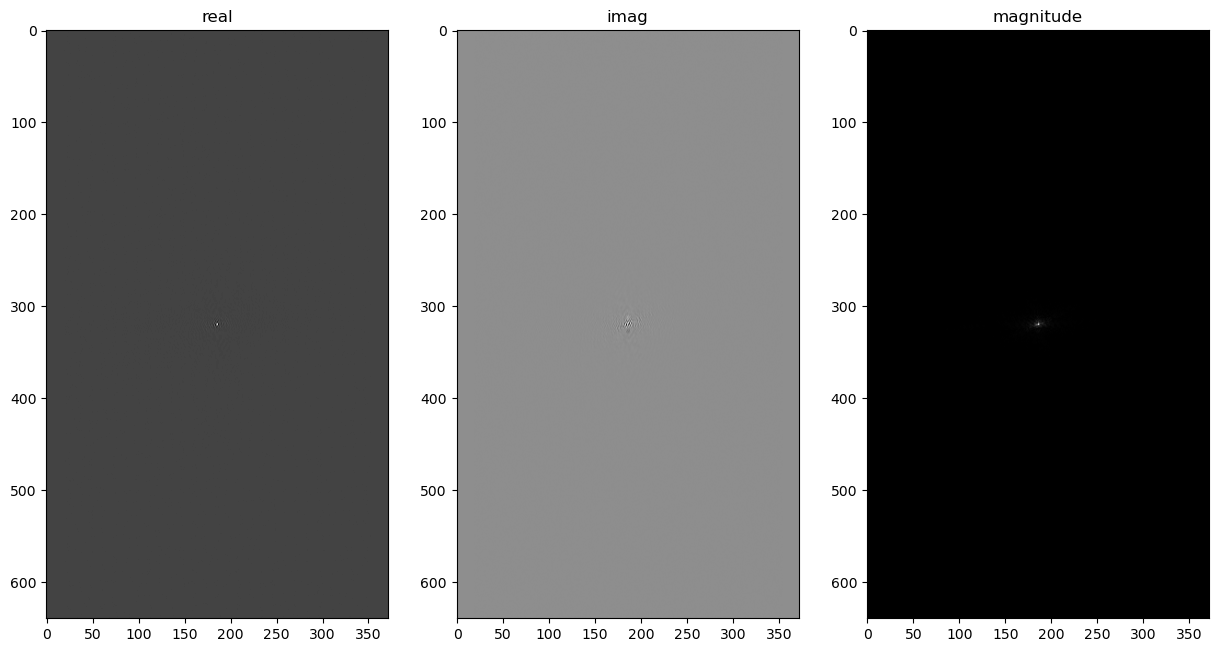

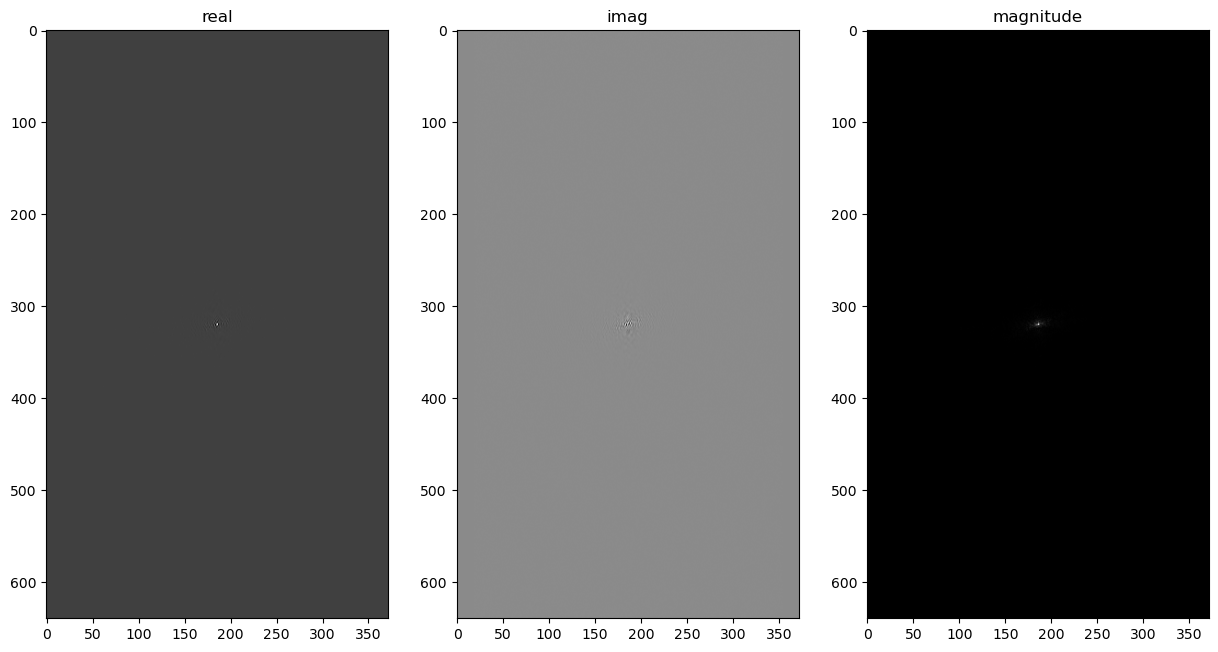

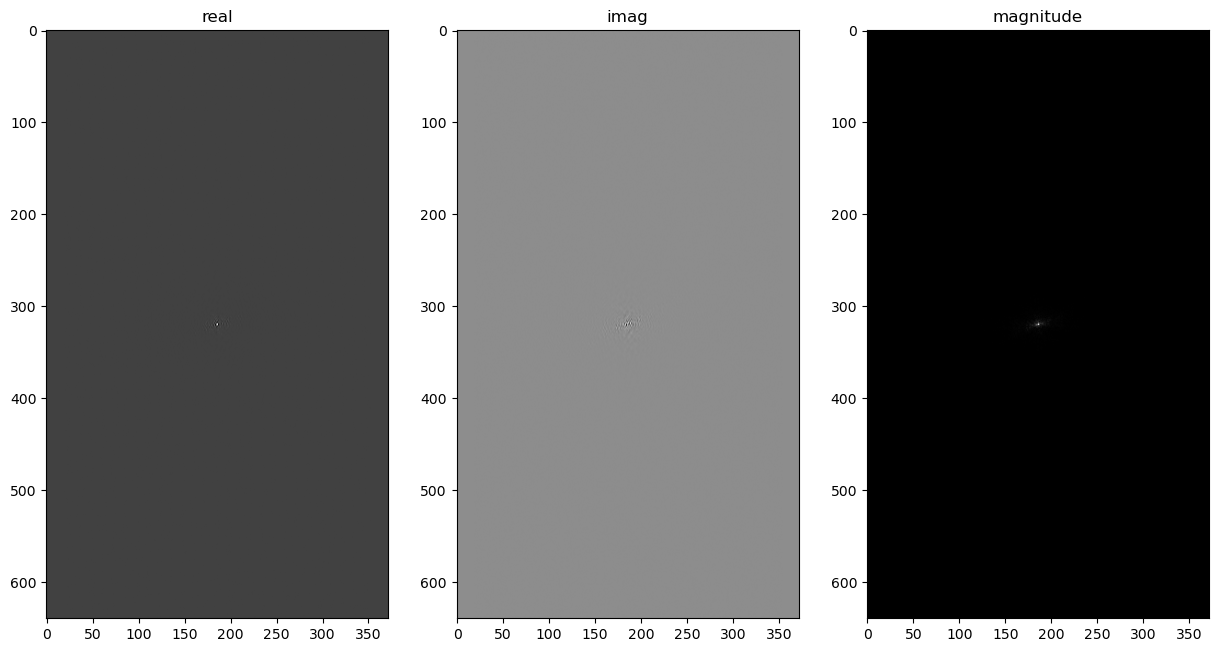

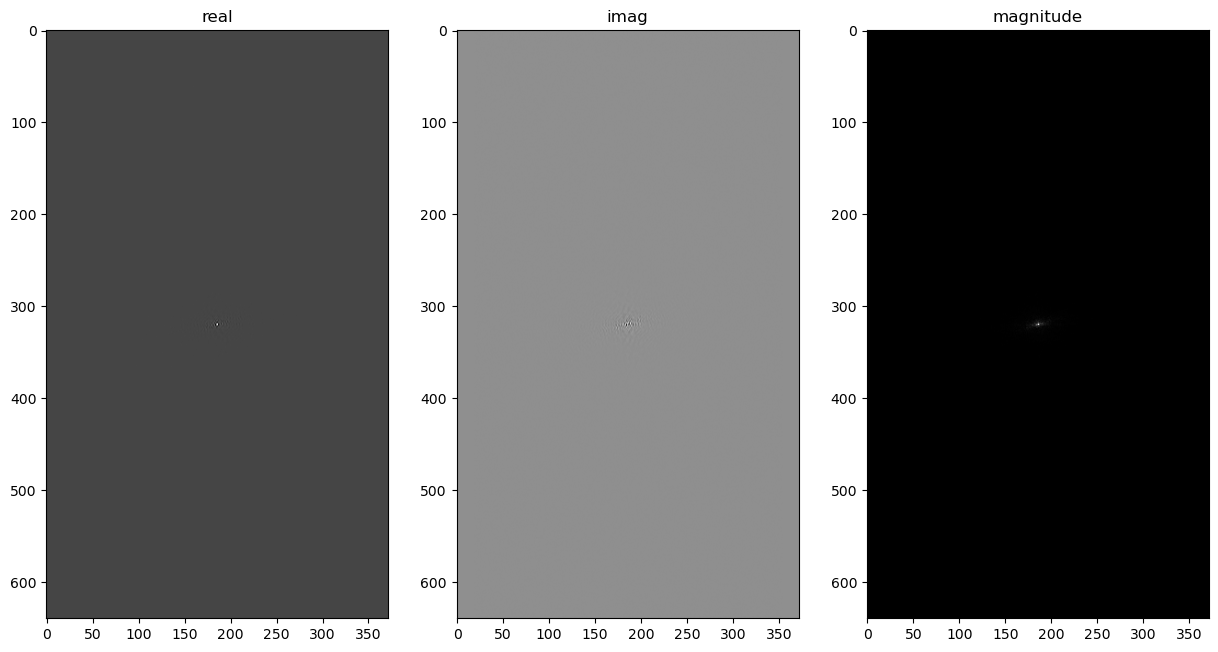

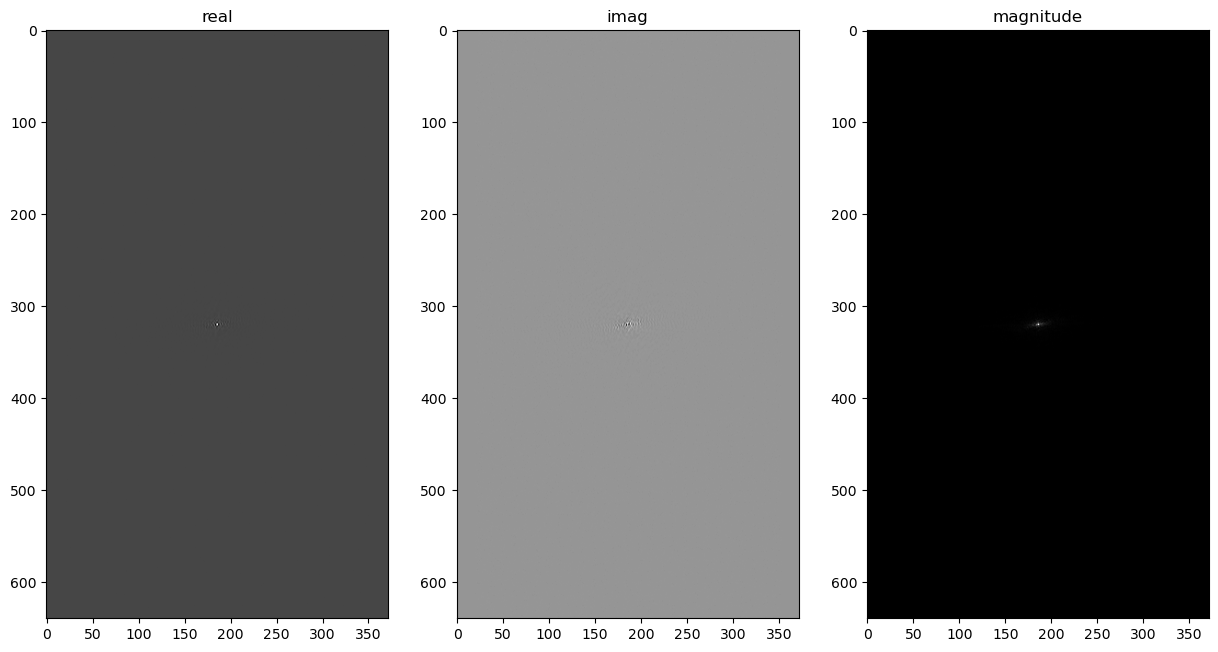

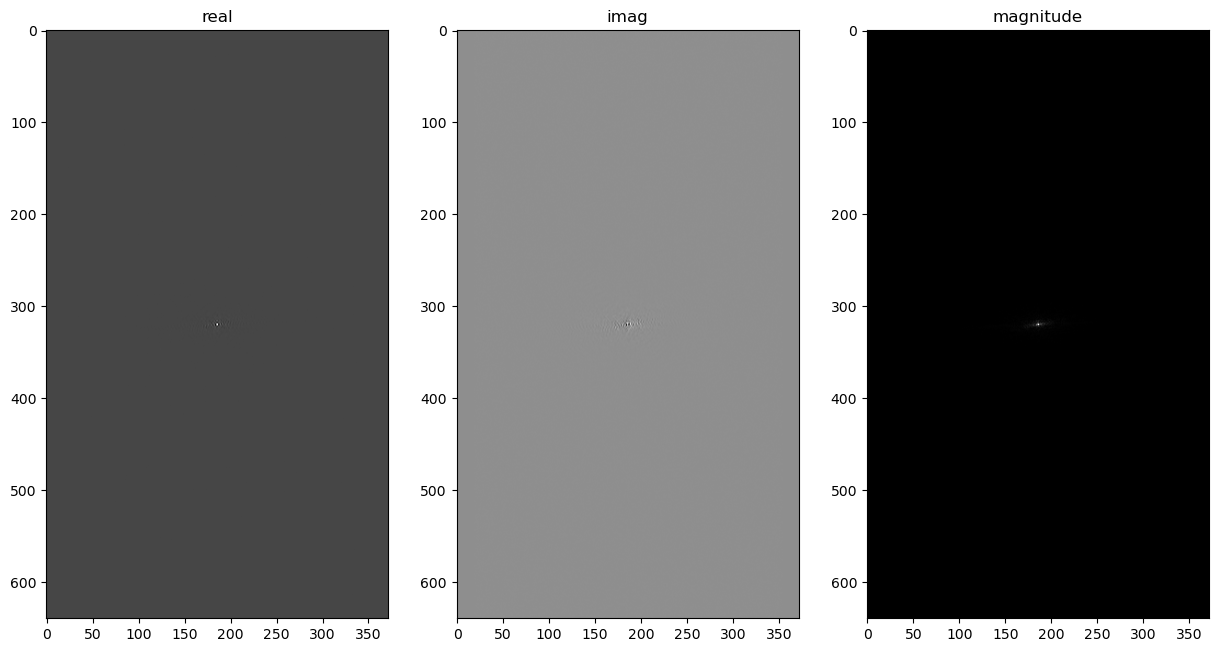

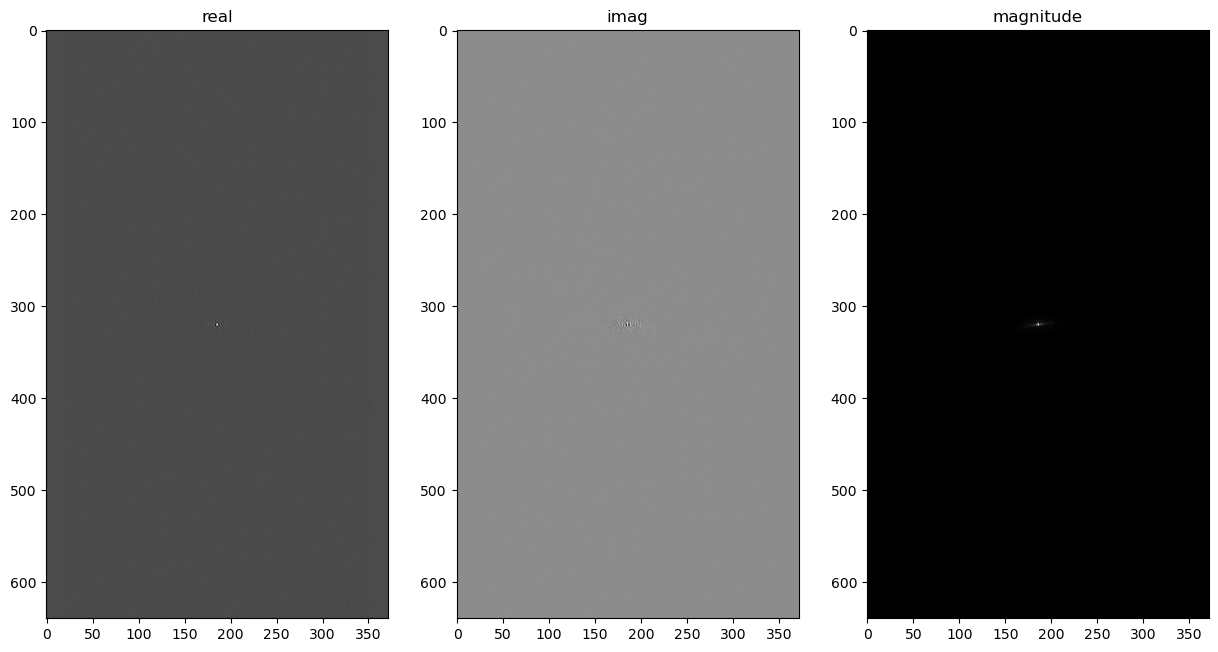

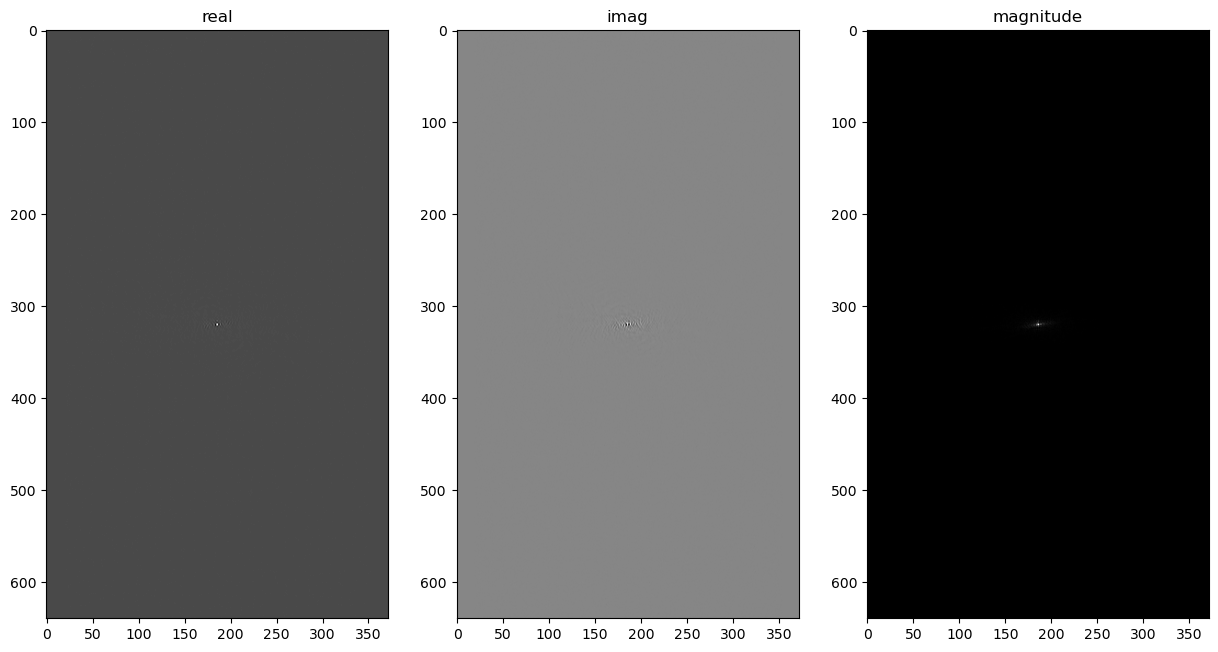

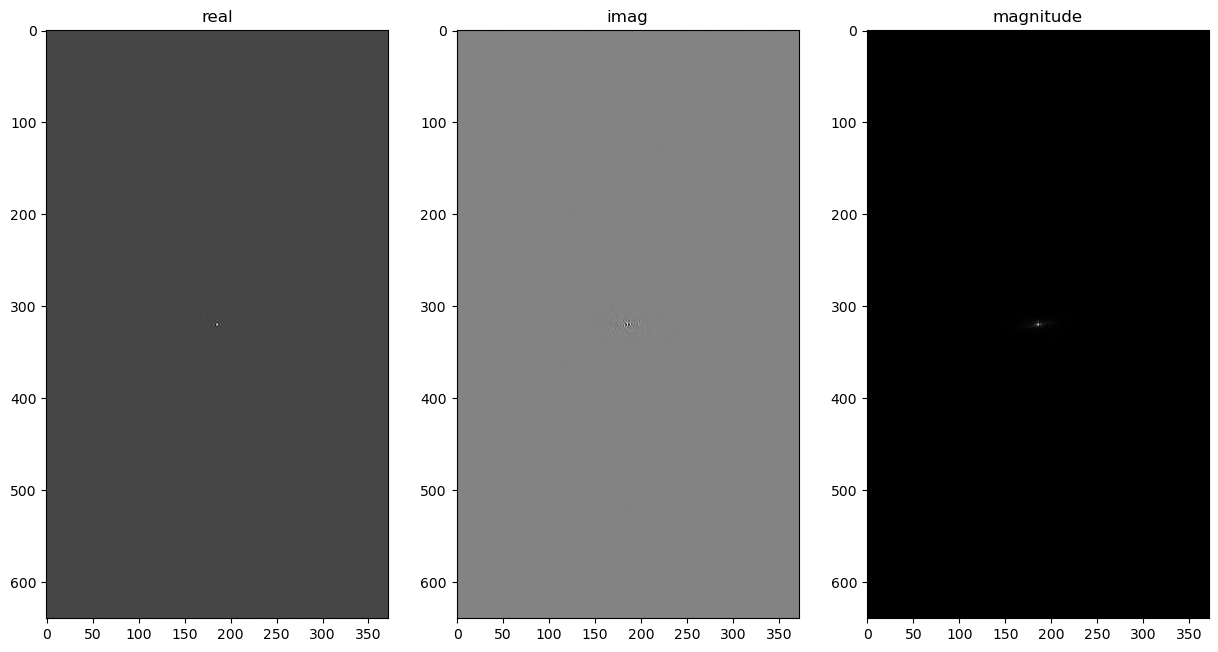

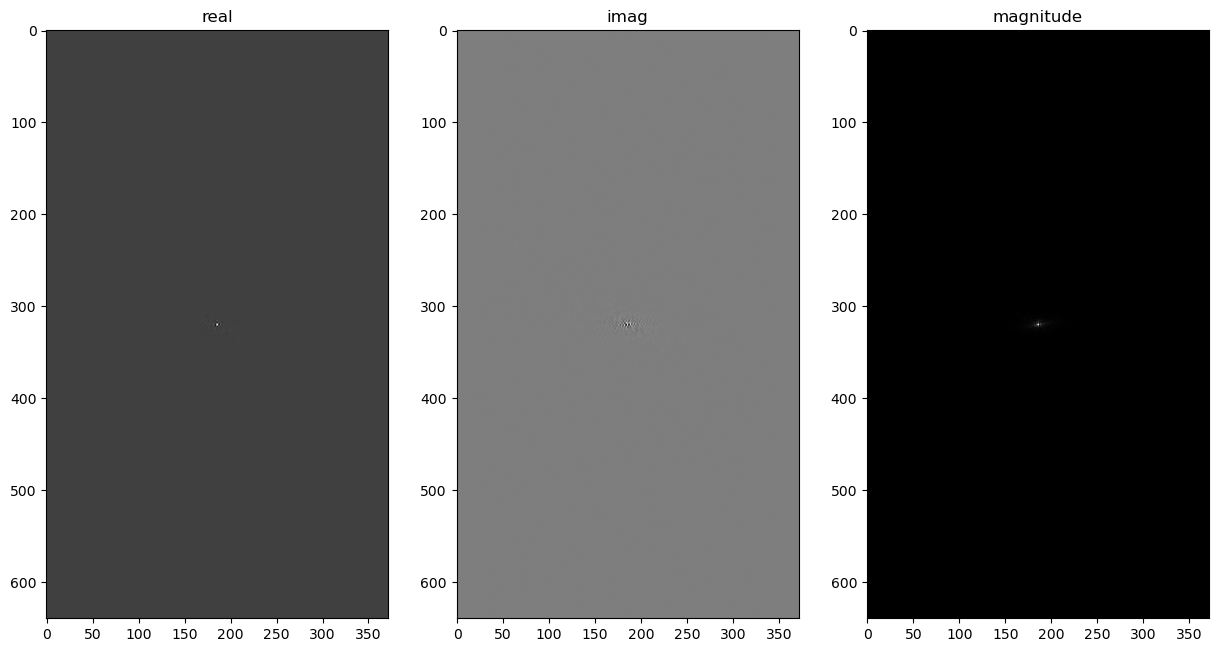

In [11]:

for slice in range(len(kspace_arr)):
    plt.figure(figsize=(15, 10))
    ax = plt.subplot(1, 3, 1)
    ax.imshow(kspace_arr[slice].real, cmap="gray")
    ax.set_title("real")
    ax = plt.subplot(1, 3, 2)
    ax.imshow(kspace_arr[slice].imag, cmap="gray")
    ax.set_title("imag")
    ax = plt.subplot(1, 3, 3)
    ax.imshow(abs(kspace_arr[slice]), cmap="gray")
    ax.set_title("magnitude")
    plt.show()

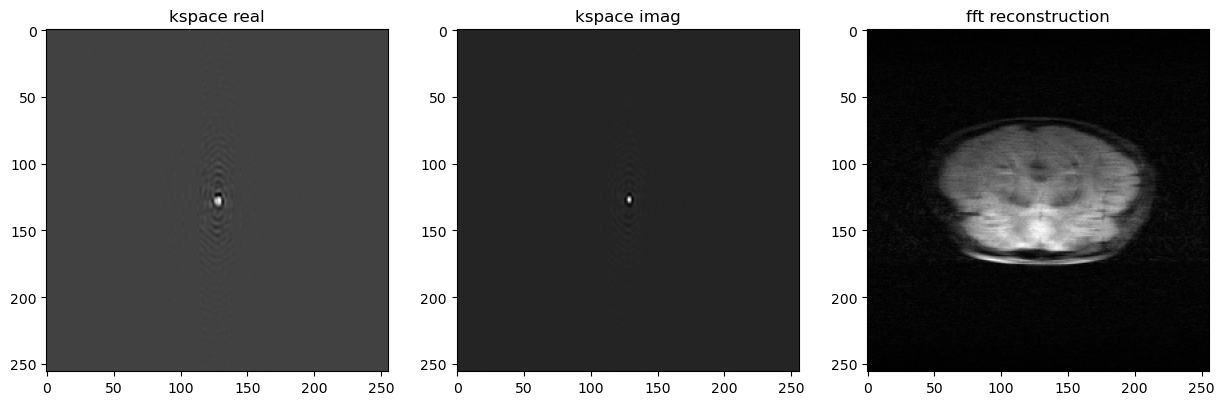

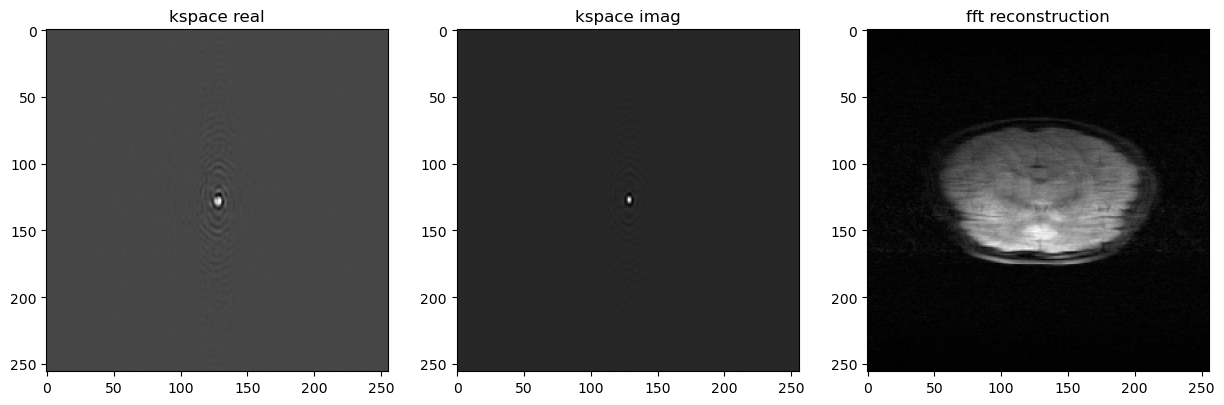

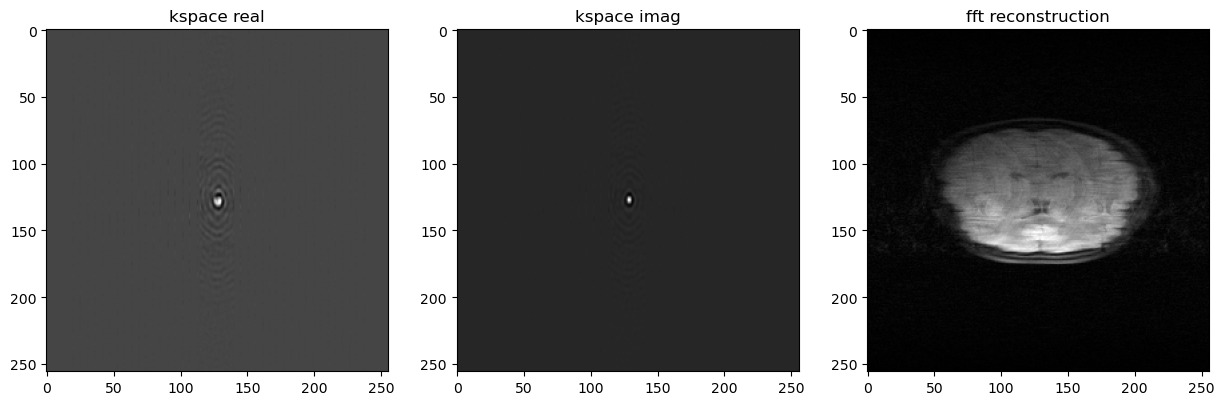

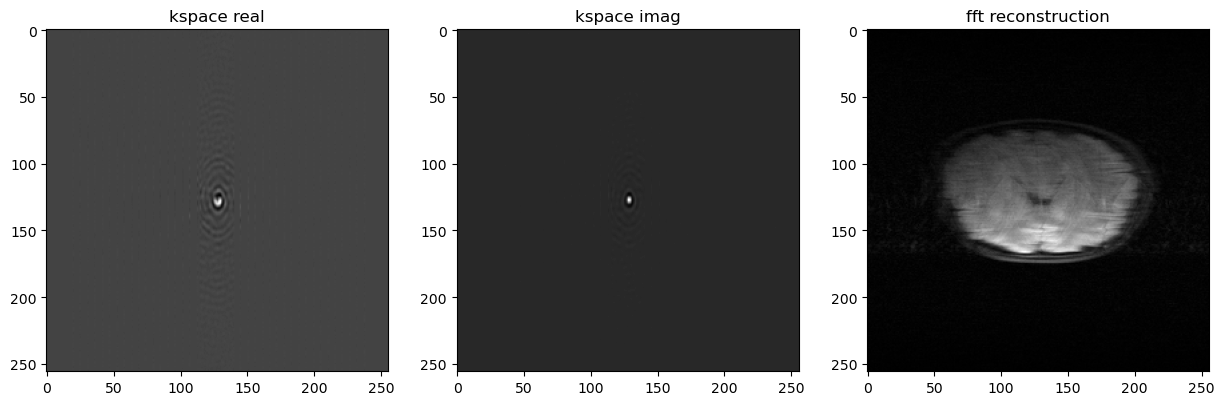

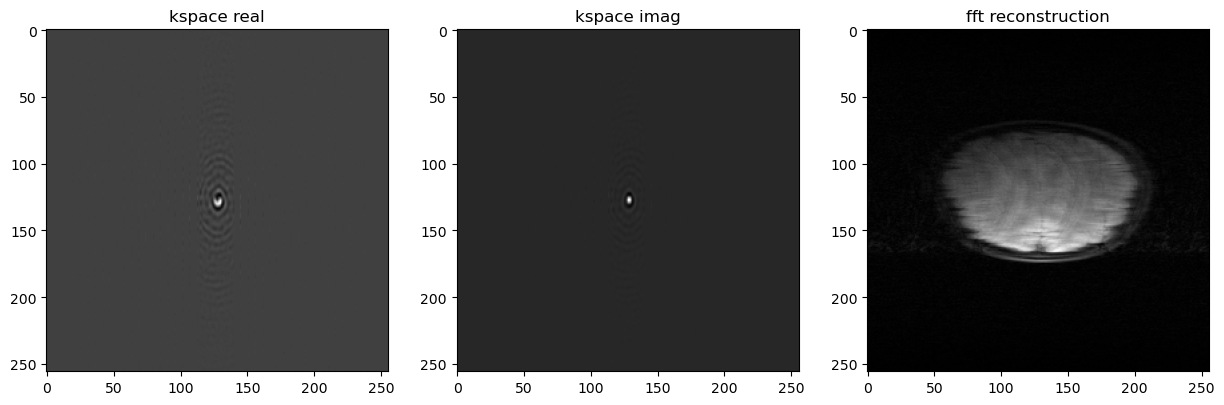

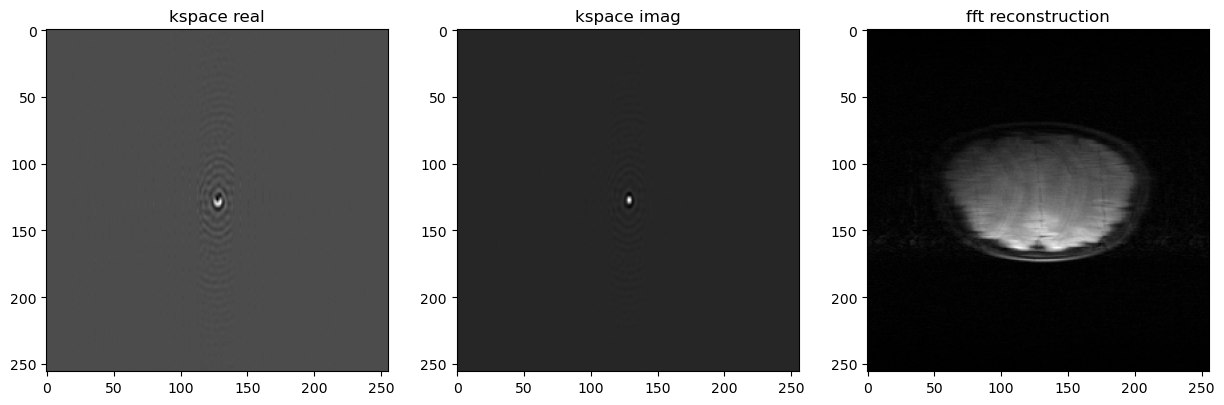

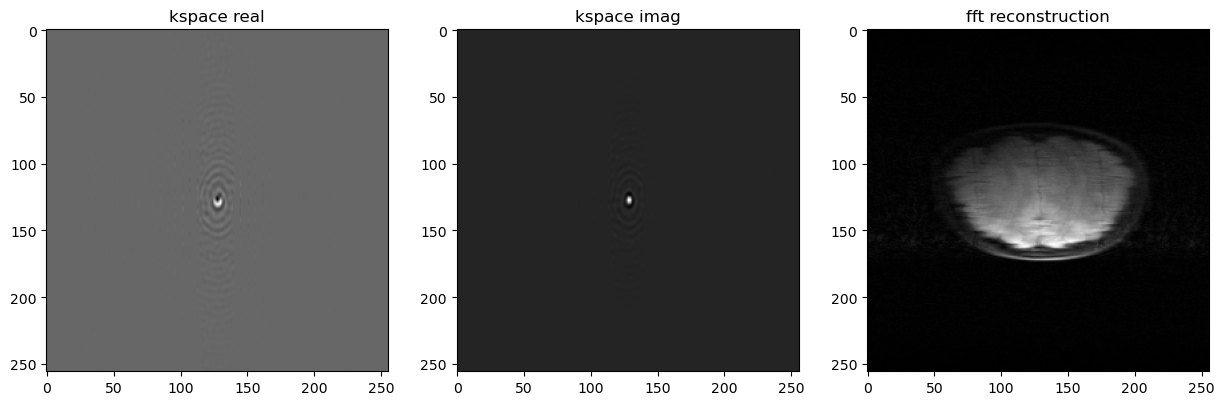

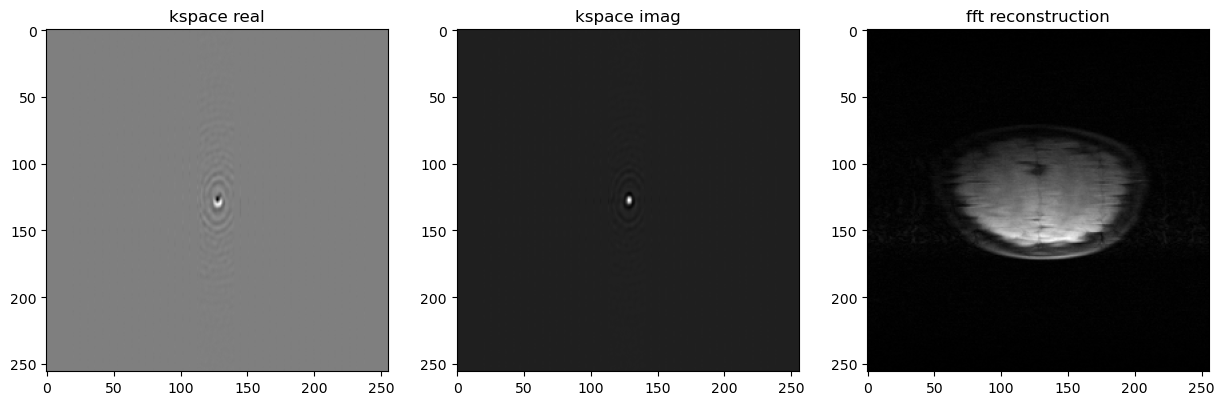

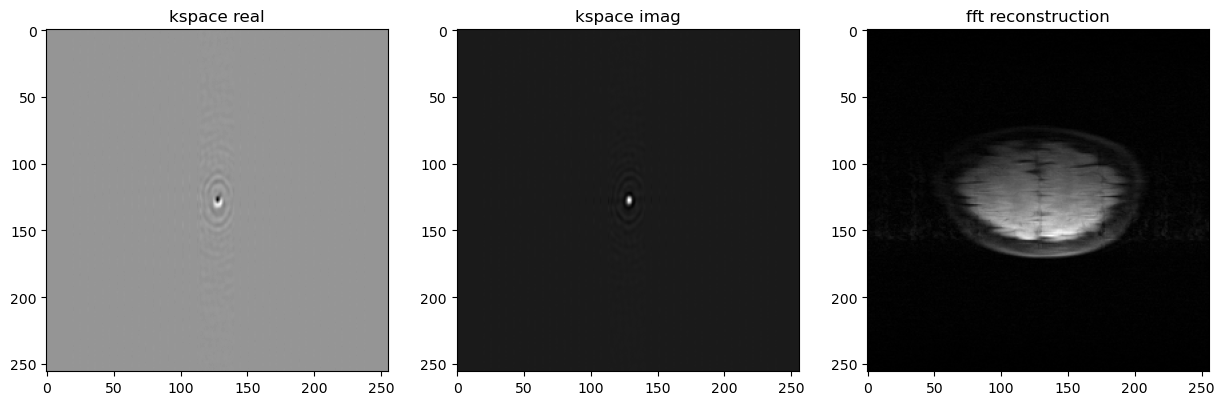

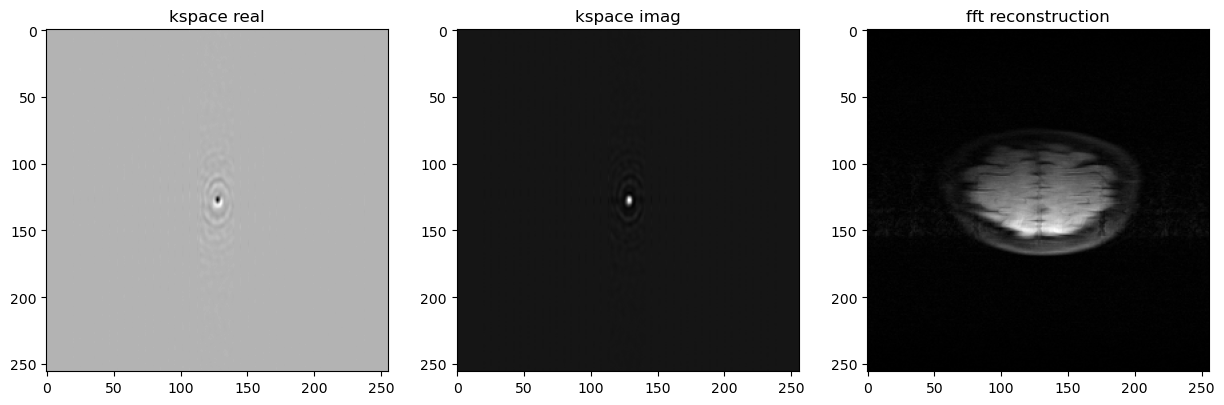

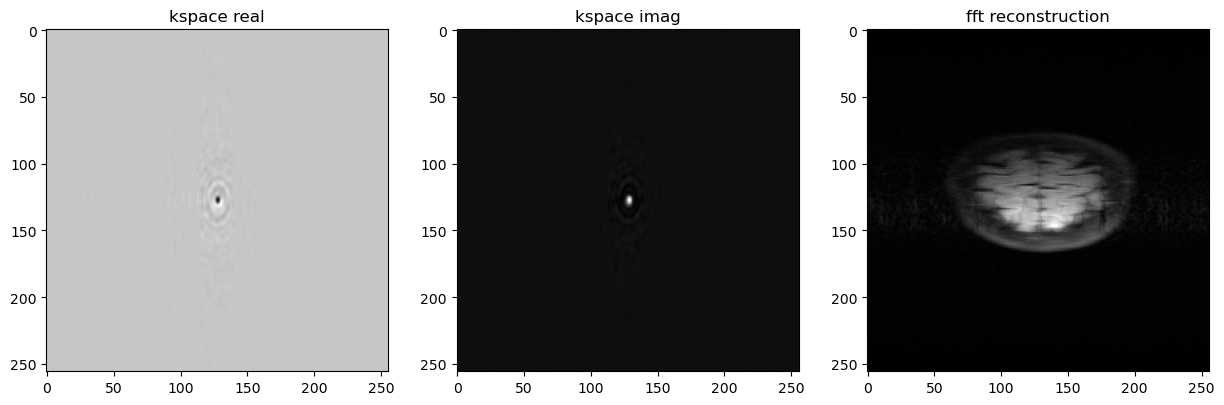

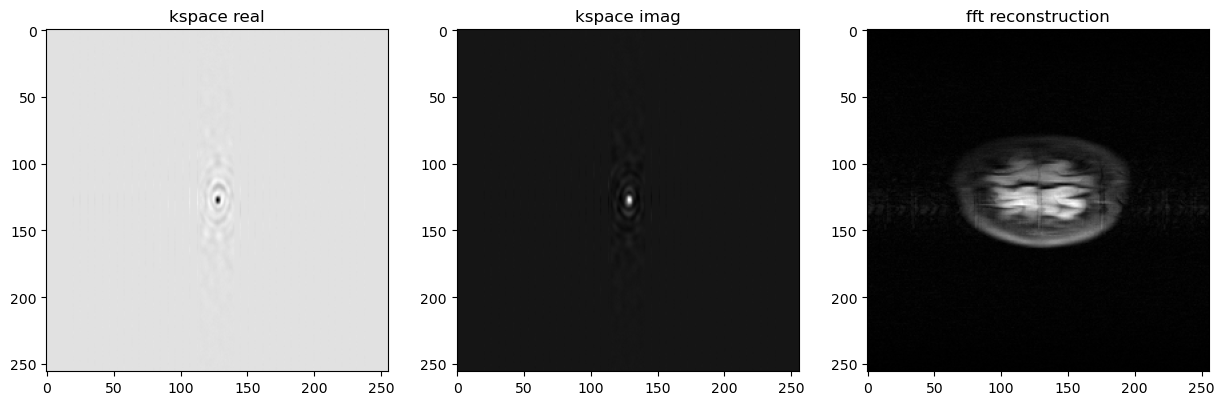

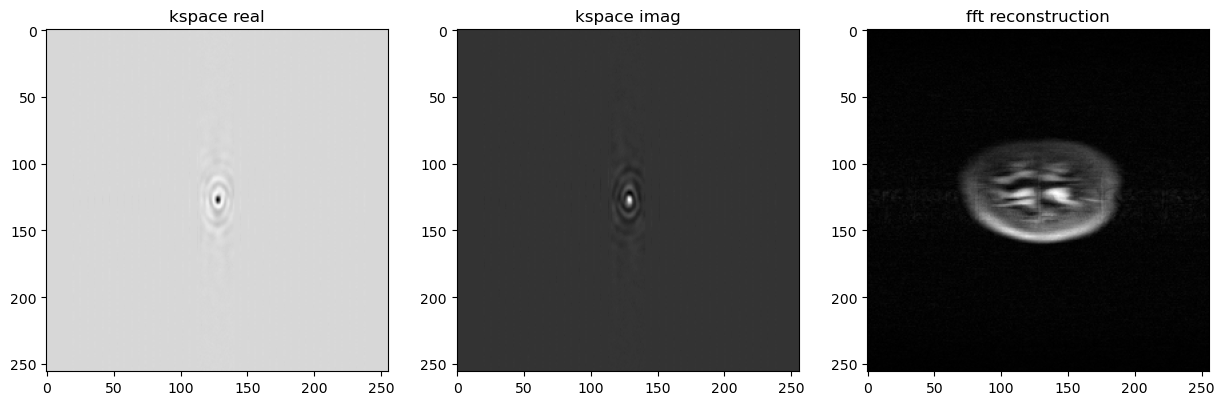

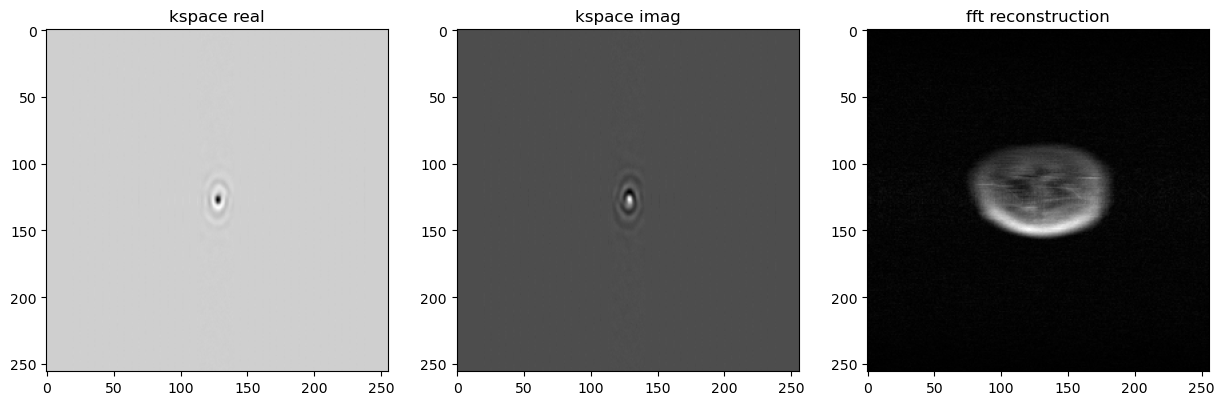

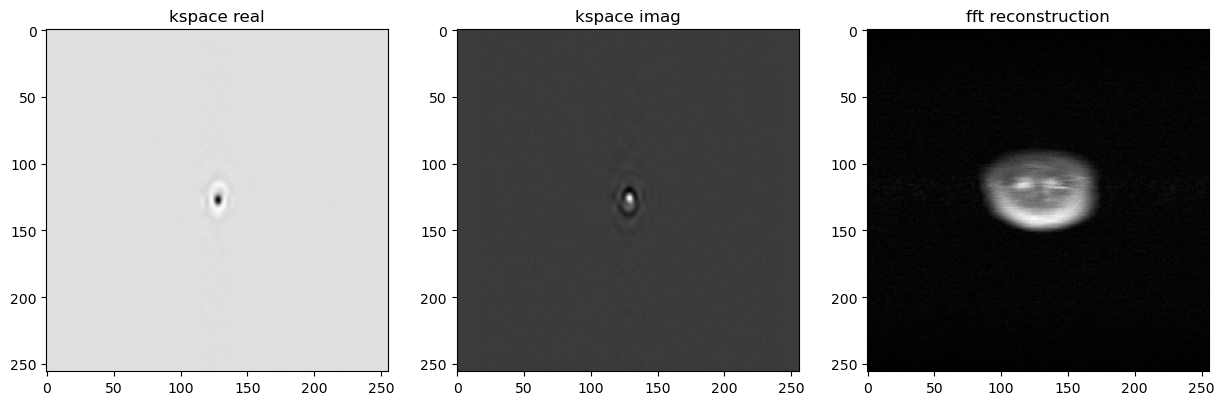

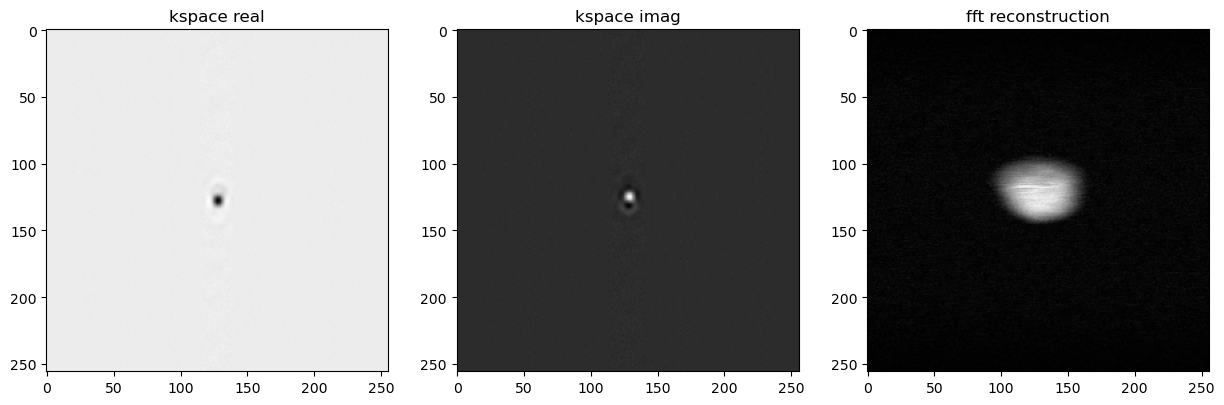

In [8]:
import scipy.fft as fft

def crop_center(img,cropx,cropy):
    y,x = img.shape
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)    
    return img[starty:starty+cropy,startx:startx+cropx]

def normalize_01(img):
    min = np.min(img)
    max = np.max(img)
    
    img_norm = (img - min) / (max - min + 1e-8)
    #img_norm = img_norm * 2 - 1
    return img_norm

def process(data_arr, slice_idx):
    data_arr = np.stack([data_arr.real, data_arr.imag], axis=0)
    norm = normalize_01(data_arr)
    final_img = (norm * 255).astype(np.uint8)
    return final_img[0], final_img[1]

def subsample_rows_random(image, factor):
    """
    Subsample input image by randomly sampling rows, reducing the number of samples by a specified factor
    Set the remainder to 0.

    Parameters:
    - image: numpy array, input image with shape (height, width)
    - factor: int, subsampling factor for rows

    Returns:
    - subsampled_image: numpy array, subsampled image
    """
    if factor <= image.shape[0] // 2:
        subsampled_image = np.zeros_like(image)
        num_samples = image.shape[0] // factor
        random_idx = np.random.permutation(image.shape[0])[:num_samples]
        subsampled_image[random_idx,:] = image[random_idx,:]
    else:
        print("error, factor chosen is too large")
        subsampled_image = image.copy()  # Return a copy to avoid modifying the original
    return subsampled_image

for slice in range(len(kspace_arr)):
    fig = plt.figure(figsize=(15, 10))
    ax = plt.subplot(1, 3, 1)
    kspace_crop = crop_center(kspace_arr[slice,1], 256, 256)
    #kspace_
    #kspace_crop = subsample_rows_random(kspace_crop, 4)
    py_recon = fft.ifftshift(fft.ifft2(fft.fftshift(kspace_crop)))
    #py_recon = crop_center(py_recon, 320, 320)
    im = ax.imshow(kspace_crop.real, cmap="gray")
    ax.set_title("kspace real")
    ax = plt.subplot(1, 3, 2)
    im = ax.imshow(kspace_crop.imag, cmap="gray")
    ax.set_title("kspace imag")
    ax = plt.subplot(1, 3, 3)
    img = abs(py_recon)
    #img = normalize_01(img)
    #img = (img * 255).astype(np.uint8)
    im = ax.imshow(img, cmap="gray")
    ax.set_title("fft reconstruction")
    plt.show()

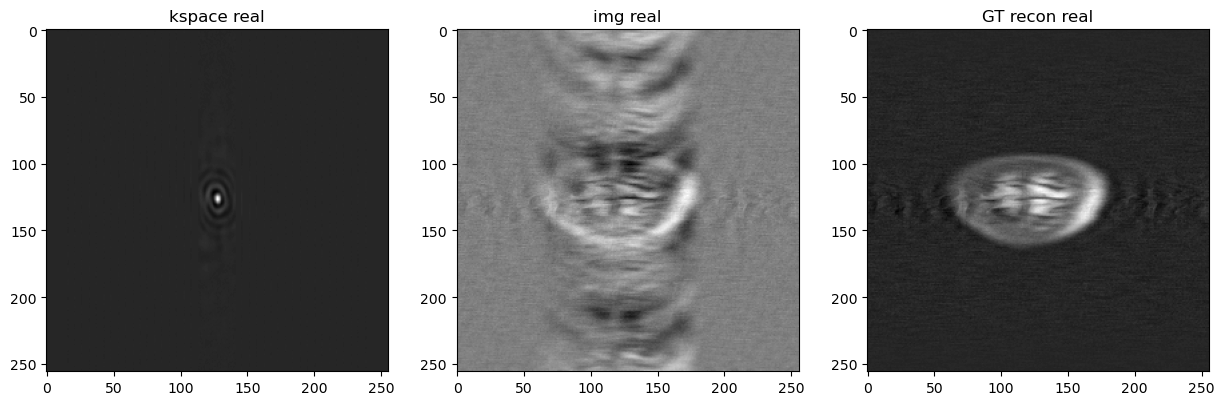

In [23]:
import numpy as np
import glob
from scipy import fft
import matplotlib.pyplot as plt
import torch

def normalize_01(img):
    min = np.min(img)
    max = np.max(img)
    
    img_norm = (img - min) / (max - min + 1e-8)
    return img_norm

def subsample_rows_random(image, factor):
    if factor <= image.shape[0] // 2:
        subsampled_image = np.zeros_like(image)
        num_samples = image.shape[0] // factor
        random_idx = np.random.permutation(image.shape[0])[:num_samples]
        subsampled_image[random_idx,:] = image[random_idx,:]
    else:
        print("error, factor chosen is too large")
        subsampled_image = image.copy()  # Return a copy to avoid modifying the original
    return subsampled_image

kspace_dir = "/data/vision/polina/users/ramyamut/projects/mri_final_project/data/brain_multicoil_test/preproc/kspace/"
kspace_paths = sorted(glob.glob(f"{kspace_dir}/*.npy"))

kspace = np.load(kspace_paths[20])
kspace_real = kspace[0]
kspace_imag = kspace[1]
kspace_complex = kspace_real + 1j*kspace_imag
recon_complex = fft.ifftshift(fft.ifft2(fft.fftshift(kspace_complex)))
recon = np.stack([recon_complex.real, recon_complex.imag], axis=0)
kspace_subsampled = subsample_rows_random(kspace_complex, 2)
img_complex = fft.ifftshift(fft.ifft2(fft.fftshift(kspace_subsampled)))
img = np.stack([img_complex.real, img_complex.imag], axis=0)

fig = plt.figure(figsize=(15, 10))
ax = plt.subplot(1, 3, 1)
im = ax.imshow(kspace[0], cmap="gray")
ax.set_title("kspace real")
ax = plt.subplot(1, 3, 2)
im = ax.imshow(img[0], cmap="gray")
ax.set_title("img real")
ax = plt.subplot(1, 3, 3)
im = ax.imshow(recon[0], cmap="gray")
ax.set_title("GT recon real")
plt.show()

In [15]:
recon_t.shape

torch.Size([2, 1, 256, 256])